# Repeater spectral analysis

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function
import pylab as pl
import numpy as np
import rtpipe, sdmpy
import rtlib_cython as rtlib
from astropy import coordinates
from scipy.optimize import curve_fit
import emcee, corner

2016-12-27 07:25:52,246 - py.warnings - WARNING - /users/claw/miniconda/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)



In [3]:
# SNR from realfast using telcal gain solutions
snrdet = {'57623': 35.2, '57633_scan7': 119.3, '57633_scan13': 16.3, '57638': 9.9, '57643': 69.9,
         '57645': 11.1, '57646': 16.0, '57648': 17.6, '57649': 25.2} 

# flux scale from Bryan
calstring = """2.0520    2.89698    0.00279
2.1800    *******    *******
2.3080    *******    *******
2.4360    3.53585    0.00377
2.5640    3.69554    0.00376
2.6920    3.85507    0.00423
2.8200    4.00438    0.00486
2.9480    4.11069    0.00562
3.0520    4.20375    0.00631
3.1800    4.29385    0.00662
3.3080    4.36557    0.00715
3.4360    4.43684    0.00786
3.5640    4.46937    0.00850
3.6920    4.52488    0.00860
3.8200    4.53571    0.00969
3.9480    4.54625    0.00859""" 
# parse flux scale
freq = []
flux = []
eflux = []
for line in calstring.split('\n'): 
    if '*' not in line:
        result = line.split()
        freq.append(float(result[0]))
        flux.append(float(result[1]))
        eflux.append(float(result[2]))
calfreq = np.array(freq)
calflux = np.array(flux)
print(calfreq, calflux)

[ 2.052  2.436  2.564  2.692  2.82   2.948  3.052  3.18   3.308  3.436
  3.564  3.692  3.82   3.948] [ 2.89698  3.53585  3.69554  3.85507  4.00438  4.11069  4.20375  4.29385
  4.36557  4.43684  4.46937  4.52488  4.53571  4.54625]


## Functions to read and analyze data

In [4]:
def getscannum(sdmfile):
    sdm = rtpipe.parsesdm.getsdm(sdmfile)
    for scan in sdm.scans():
        try:
            print('Scan {0} binary data file: {1}'.format(scan.idx, scan.bdf.fname))
            bdfscan = int(scan.idx)
        except IOError:
            pass
    return bdfscan

def read_cut(sdmfile, scan, segment, dm=558., dt=1, gainfile=None, **kwargs):
    if not gainfile:
        gainfile = '.'.join(sdmfile.split('.')[:-1] + ['GN'])

    st = rtpipe.RT.set_pipeline(sdmfile, scan, dmarr=[dm], dtarr=[dt], flaglist=[('badap', 3., 0.2)], 
                                uvoversample=1.5, gainfile=gainfile, flagantsol=True, 
                                timesub='mean', logfile=False, savecands=False,
                                savenoise=False, **kwargs)
        
    data = rtpipe.RT.pipeline_reproduce(st, candloc=[segment,0,0,0,0], product='data')
    u, v, w = rtpipe.parsesdm.get_uvw_segment(st, segment)

    return st, data, u, v, w

def imloc(st, data, u, v, w, integ, verbose=0, weight='uniform'):
    if weight == 'uniform':
        weightarr = np.ones_like(data)
    elif weight == 'uvdist':
        uvd = np.sqrt(u**2+v**2)
        weightarr = np.ones_like(data)
        for bl in range(st['nbl']):
            weightarr[:,bl] *= uvd[bl]/uvd.max()

    im = rtpipe.RT.sample_image(st, data*weightarr, u, v, w, i=integ)
    l,m = rtpipe.RT.calc_lm(st, im)
    ra_center, dec_center = st['radec']
    ra, dec = rtpipe.reproduce.source_location(ra_center, dec_center, l, m)
    ras = ra.split()
    decs = dec.split()
    loc = coordinates.SkyCoord('{0}h{1}m{2}s'.format(ras[0], ras[1], ras[2]),
                               '{0}d{1}m{2}s'.format(decs[0], decs[1], decs[2]), frame='icrs')

    if verbose:
        print('Peak location:')
        print(l, m)
        print(loc.ra.hms, loc.dec.dms)
    return im, loc

def correctdata(st, data, u, v, w, corr='ph,dm', lm = (-3.85e-04,5.45e-04)):
    data2 = data.copy()
    
    if 'ph' in corr:
        l1, m1 = lm
        rtlib.phaseshift_threaded(data2, st, l1, m1, u, v)

    if 'dm' in corr:
        rtlib.dedisperse_par(data2, st['freq'], st['inttime'], st['dmarr'][0], [0, st['nbl']])
    
    return data2

# get array2 for bin in array near value
def find_nearest(array, array2, value):
    idx = (np.abs(array-value)).argmin()
    return array2[idx]

def getscale(st):
    # get flux scaling at nearest frequency
    scale = []
    for i in range(len(st['freq'])):
        freq = st['freq'][i]
        scale.append(find_nearest(calfreq, calflux, freq))
#         print(i, st['freq'][i], scale)
    scale = np.array(scale, dtype='complex64')[None,None,:,None]
    return scale

def correct_all(st, data, u, v, w):
    scale = getscale(st)
    dataph = correctdata(st, data*scale, u, v, w, corr='ph')
    dataphdm = correctdata(st, dataph, u, v, w, corr='dm')
    return dataphdm

def correct_and_plot(st, data, u, v, w, integ):
    scale = getscale(st)
    dataph = correctdata(st, data*scale, u, v, w, corr='ph')
    dataphdm = correctdata(st, dataph, u, v, w, corr='dm')

    fig = pl.figure(figsize=(15,8))
    ax = fig.add_subplot(131)
    sgram = dataphdm[integ-10:integ+10].mean(axis=3).mean(axis=1).real.transpose()
    pl.imshow(sgram, interpolation='nearest', origin='lower', cmap='viridis')
    pl.xlabel('Integration')
    pl.ylabel('Channel')
    ax = fig.add_subplot(132)
    spectra = dataphdm[integ-10:integ+10].mean(axis=2).mean(axis=1).real
    pl.plot(spectra[:,0], 'c.', label='RR')
    pl.plot(spectra[:,1], 'm.', label='LL')
    pl.legend()
    pl.xlabel('Integration')
    pl.ylabel('Amplitude')
    ax = fig.add_subplot(133)
    datadm = correctdata(st, data*scale, u, v, w, corr='dm')
    im, loc = imloc(st, datadm, u, v, w, integ, verbose=1)
    pl.imshow(im.transpose(), interpolation='nearest', cmap='viridis', aspect='equal')
    print('Image SNR {0}'.format(im.max()/im.std()))
    pl.xlabel('RA offset (pix)', fontsize=20)
    pl.ylabel('Dec offset (pix)', fontsize=20)
    xt = pl.setp(ax.get_xticklabels(), fontsize=14)
    yt = pl.setp(ax.get_yticklabels(), fontsize=14)
    ax.xaxis.set_tick_params(width=3, color='w')
    ax.yaxis.set_tick_params(width=3, color='w')

    fig = pl.figure(figsize=(3,6))
    ax = fig.add_subplot(111)
    sgram = dataph[integ-10:integ+50].mean(axis=3).mean(axis=1).real.transpose()
    extent = (0, 60*st['inttime'], st['freq'][0], st['freq'][-1])
    pl.imshow(sgram, interpolation='nearest', origin='lower', cmap='viridis',
              vmax=sgram.max()*0.8, extent=extent)
    pl.xlabel('Time (s, relative)', fontsize=14)
    pl.ylabel('Frequency (GHz)', fontsize=14)
    xt = pl.setp(ax.get_xticklabels(), fontsize=14)
    yt = pl.setp(ax.get_yticklabels(), fontsize=14)
    ax.xaxis.set_tick_params(width=2, color='k')
    ax.yaxis.set_tick_params(width=2, color='k')
    pl.xticks(np.linspace(0, 60*st['inttime'], 4))
    pl.colorbar()

    fig = pl.figure(figsize=(6,3))
    ax = fig.add_subplot(111)
    spectra = dataphdm[integ].mean(axis=0).real
    print('(RR-LL)/(RR+LL): {0}'.format(np.mean((spectra[:,0]-spectra[:,1])).real/np.mean((spectra[:,0]+spectra[:,1])).real))
    print('(RR+LL): {0}'.format(np.mean((spectra[:,0]+spectra[:,1])).real))
    nint, nbl, nch, npol = data.shape
    pl.scatter(range(0, nch), spectra[:,0], marker='.', c='c', label='RR', edgecolors='none')
    pl.scatter(range(0, nch), spectra[:,1], marker='.', c='m', label='LL', edgecolors='none')
    resamp = 16
    minch = 0
    if nch < 256:
        minch = resamp - (256-nch)
    print(minch, nch, resamp, spectra[minch:,0].shape)
    pl.scatter(range(minch, nch, resamp), spectra[minch:,0].reshape((256-minch)/resamp, resamp).mean(axis=1), 
               marker='_', c='c', s=500, edgecolors='c')
    pl.scatter(range(minch, nch, resamp), spectra[minch:,1].reshape((256-minch)/resamp, resamp).mean(axis=1), 
               marker='_', c='m', s=500, edgecolors='m')

    off = np.ma.masked_equal(dataphdm.mean(axis=1).real[range(0,integ-2)+range(integ+3,len(dataphdm))], 0)
    noise = off.std(axis=0)
    noiseRR = np.median(noise[:,0])
    noiseLL = np.median(noise[:,1])
    pl.errorbar(230, spectra.max(), yerr=noiseRR, fmt='c.', ecolor='c')
    pl.text(230, spectra.max(), s='RR', verticalalignment='center', horizontalalignment='left')
    pl.errorbar(240, spectra.max(), yerr=noiseLL, fmt='m.', ecolor='m')
    pl.text(240, spectra.max(), s='LL', verticalalignment='center', horizontalalignment='left')
#    pl.errorbar(range(nch), spectra[:,0], yerr=noise[:,0], fmt='c.', ecolor='c')
#    pl.errorbar(range(nch), spectra[:,1], yerr=noise[:,1], fmt='m.', ecolor='m')
#    pl.legend()
    pl.xlabel('Frequency (GHz)', fontsize=14)
    pl.ylabel('Flux density (Jy)', fontsize=14)
    pl.xlim(-5, nch+5)
    pl.xticks(range(0, nch+1, 32), [str(np.round(st['freq'][0]+ch*0.004, 2)) for ch in range(0, nch+1, 32)])
    xt = pl.setp(ax.get_xticklabels(), fontsize=14)
    yt = pl.setp(ax.get_yticklabels(), fontsize=14)
    ax.xaxis.set_tick_params(width=2, color='k')
    ax.yaxis.set_tick_params(width=2, color='k')
    return spectra

def getwidespectrum(st, data, u, v, w, i0, i1):
    scale = getscale(st)
    dataph = correctdata(st, data*scale, u, v, w, corr='ph')
    dataphdm = correctdata(st, dataph, u, v, w, corr='dm')
    spectrum = dataphdm[i0:i1].mean(axis=3).mean(axis=1).real
    return spectrum

def find_dm(st, data, u, v, w):
    scale = getscale(st)

    dmorig = st['dmarr']
    snrs = []
    for dm in range(530, 600, 2):
        st['dmarr'] = [dm]
        datadm = correctdata(st, data*scale, u, v, w, corr='dm')
        datadmph = correctdata(st, datadm, u, v, w, corr='ph')
        lc = datadmph.mean(axis=3).mean(axis=2).mean(axis=1).real
        integ = np.where(lc.max() == lc)[0][0]
        im, loc = imloc(st, datadm, u, v, w, integ)
        imc = im.transpose()[-1000:, 1000:]
        mad = np.median(np.abs(imc - np.median(imc)))
        std = mad/0.67
        snr = im.max()/std
        snrs.append((dm, integ, snr))
    st['dmarr'] = dmorig

    snrs = np.array(snrs)
    snrmax_ind = np.where(snrs[:,2] == snrs[:,2].max())[0][0]
    print('SNR vs DM: {0}'.format(snrs))
    print('Max SNR of {0} at DM={1}'.format(snrs[snrmax_ind, 2], snrs[snrmax_ind, 0]))
    return snrs[snrmax_ind]

In [5]:
read = {}
spectrum = {}
spectrumwide = {}
dmmax = {}

In [6]:
cd ~/16A-459/fastimaging/

/lustre/aoc/projects/16A-459/fastimaging


In [7]:
sdmfile = '16A-459_TEST_1hr.57623.72670021991.cut'
key = '57623'
scannum = getscannum(sdmfile)
read[key] = read_cut(sdmfile, scannum, 2, npix_max=4096)

2016-12-27 07:25:54,936 - rtpipe.parsesdm - INFO - Setting (standard) key logfile to False
2016-12-27 07:25:54,937 - rtpipe.parsesdm - INFO - Setting (standard) key timesub to mean
2016-12-27 07:25:54,938 - rtpipe.parsesdm - INFO - Setting (standard) key gainfile to 16A-459_TEST_1hr.57623.72670021991.GN
2016-12-27 07:25:54,939 - rtpipe.parsesdm - INFO - Setting (standard) key dmarr to [558.0]
2016-12-27 07:25:54,940 - rtpipe.parsesdm - INFO - Setting (standard) key dtarr to [1]
2016-12-27 07:25:54,940 - rtpipe.parsesdm - INFO - Setting (standard) key npix_max to 4096
2016-12-27 07:25:54,941 - rtpipe.parsesdm - INFO - Setting (standard) key savecands to False
2016-12-27 07:25:54,942 - rtpipe.parsesdm - INFO - Setting (standard) key flaglist to [('badap', 3.0, 0.2)]
2016-12-27 07:25:54,943 - rtpipe.parsesdm - INFO - Setting (standard) key savenoise to False
2016-12-27 07:25:54,944 - rtpipe.parsesdm - INFO - Setting (standard) key flagantsol to True
2016-12-27 07:25:54,944 - rtpipe.parses

Scan 6 binary data file: /lustre/aoc/projects/16A-459/fastimaging/16A-459_TEST_1hr.57623.72670021991.cut/ASDMBinary/uid____evla_bdf_1471974264507


2016-12-27 07:25:55,239 - rtpipe.parsesdm - WARNING - No BDF found for scans [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14]
2016-12-27 07:25:55,313 - rtpipe.parsesdm - INFO - Calculating uvw for first integration of scan 6 of source FRB121102-off
2016-12-27 07:25:55,471 - rtpipe.parsesdm - INFO - 

2016-12-27 07:25:55,472 - rtpipe.parsesdm - INFO - Metadata summary:
2016-12-27 07:25:55,473 - rtpipe.parsesdm - INFO - 	 Working directory and data at /lustre/aoc/projects/16A-459/fastimaging, 16A-459_TEST_1hr.57623.72670021991.cut
2016-12-27 07:25:55,474 - rtpipe.parsesdm - INFO - 	 Using scan 6, source FRB121102-off
2016-12-27 07:25:55,475 - rtpipe.parsesdm - INFO - 	 nants, nbl: 27, 351
2016-12-27 07:25:55,476 - rtpipe.parsesdm - INFO - 	 Freq range (2.489 -- 3.509). 8 spw with 256 chans.
2016-12-27 07:25:55,477 - rtpipe.parsesdm - INFO - 	 Scan has 800 ints (4.0 s) and inttime 0.005 s
2016-12-27 07:25:55,477 - rtpipe.parsesdm - INFO - 	 2 polarizations: ['RR', 'LL']
2016-12-27 07:25:55,47

In [8]:
key = '57623'
st, data, u, v, w = read[key]
snrmax = find_dm(st, data, u, v, w)

Gridded 1.000 of data. Scaling fft by = 51.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 51.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 51.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 51.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 51.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 51.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 51.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 51.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 51.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 51.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 51.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"
Gridded 1.

Gridded 1.000 of data. Scaling fft by = 51.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"
Peak location:
-0.000382092830009 0.000539752492877
hms_tuple(h=5.0, m=31.0, s=58.726811858099168) dms_tuple(d=33.0, m=8.0, s=52.331952522986285)
Image SNR 35.9967782898
(RR-LL)/(RR+LL): -0.0121865458786
(RR+LL): 0.255277872086
0 256 16 (256,)
Image SNR (orig): 35.2


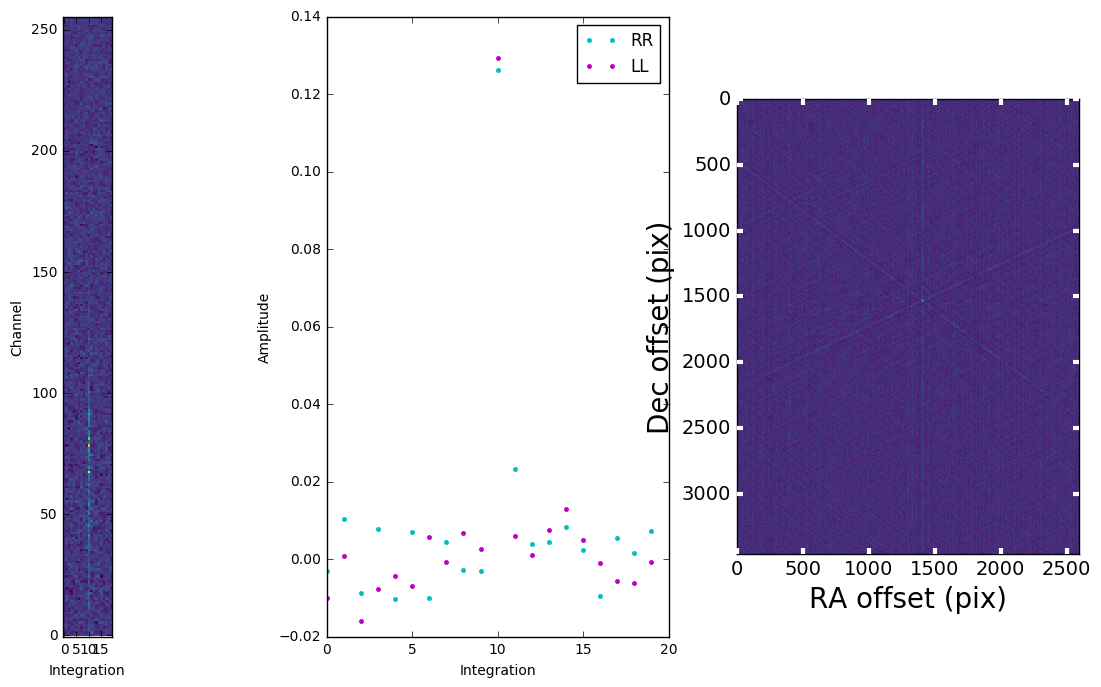

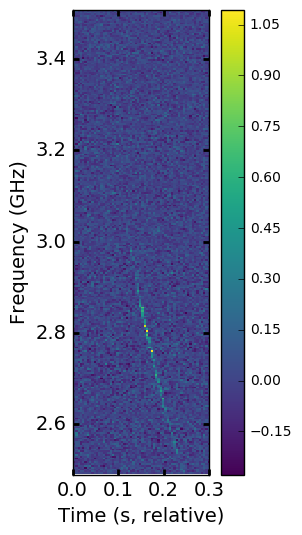

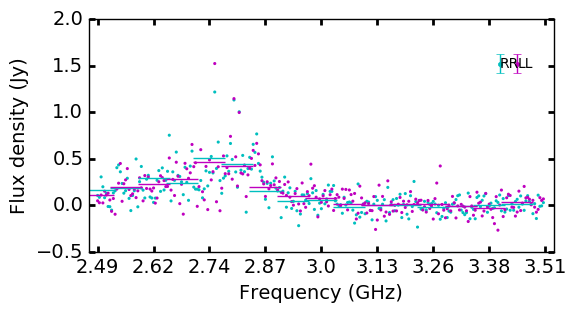

In [9]:
dmmax[key] = snrmax
dm = snrmax[0]
integ = int(snrmax[1])
st['dmarr'] = [dm]
spectrum[key] = correct_and_plot(st, data, u, v, w, integ)
i0 = integ - 1
i1 = integ + 2
spectrumwide[key] = getwidespectrum(st, data, u, v, w, i0, i1)
print('Image SNR (orig): {0}'.format(snrdet[key]))

In [10]:
sdmfile = '16A-459_TEST_1hr_000.57633.66130137732.scan7.cut'
key = '57633_scan7'
scannum = getscannum(sdmfile)
read[key] = read_cut(sdmfile, scannum, 2, gainfile='16A-459_TEST_1hr_000.57633.66130137732.GN',
                               npix_max=4096)

2016-12-27 07:27:41,844 - rtpipe.parsesdm - INFO - Setting (standard) key logfile to False
2016-12-27 07:27:41,845 - rtpipe.parsesdm - INFO - Setting (standard) key timesub to mean
2016-12-27 07:27:41,846 - rtpipe.parsesdm - INFO - Setting (standard) key gainfile to 16A-459_TEST_1hr_000.57633.66130137732.GN
2016-12-27 07:27:41,846 - rtpipe.parsesdm - INFO - Setting (standard) key dmarr to [558.0]
2016-12-27 07:27:41,847 - rtpipe.parsesdm - INFO - Setting (standard) key dtarr to [1]
2016-12-27 07:27:41,848 - rtpipe.parsesdm - INFO - Setting (standard) key npix_max to 4096
2016-12-27 07:27:41,848 - rtpipe.parsesdm - INFO - Setting (standard) key savecands to False
2016-12-27 07:27:41,849 - rtpipe.parsesdm - INFO - Setting (standard) key flaglist to [('badap', 3.0, 0.2)]
2016-12-27 07:27:41,850 - rtpipe.parsesdm - INFO - Setting (standard) key savenoise to False
2016-12-27 07:27:41,851 - rtpipe.parsesdm - INFO - Setting (standard) key flagantsol to True
2016-12-27 07:27:41,851 - rtpipe.pa

Scan 7 binary data file: /lustre/aoc/projects/16A-459/fastimaging/16A-459_TEST_1hr_000.57633.66130137732.scan7.cut/ASDMBinary/uid____evla_bdf_1472832853393


2016-12-27 07:27:42,138 - rtpipe.parsesdm - WARNING - No BDF found for scans [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14]
2016-12-27 07:27:42,210 - rtpipe.parsesdm - INFO - Calculating uvw for first integration of scan 7 of source FRB121102-off
2016-12-27 07:27:42,311 - rtpipe.parsesdm - INFO - 

2016-12-27 07:27:42,312 - rtpipe.parsesdm - INFO - Metadata summary:
2016-12-27 07:27:42,313 - rtpipe.parsesdm - INFO - 	 Working directory and data at /lustre/aoc/projects/16A-459/fastimaging, 16A-459_TEST_1hr_000.57633.66130137732.scan7.cut
2016-12-27 07:27:42,313 - rtpipe.parsesdm - INFO - 	 Using scan 7, source FRB121102-off
2016-12-27 07:27:42,314 - rtpipe.parsesdm - INFO - 	 nants, nbl: 27, 351
2016-12-27 07:27:42,315 - rtpipe.parsesdm - INFO - 	 Freq range (2.489 -- 3.509). 8 spw with 256 chans.
2016-12-27 07:27:42,316 - rtpipe.parsesdm - INFO - 	 Scan has 800 ints (4.0 s) and inttime 0.005 s
2016-12-27 07:27:42,316 - rtpipe.parsesdm - INFO - 	 2 polarizations: ['RR', 'LL']
2016-12-27 0

Gridded 1.000 of data. Scaling fft by = 60.0
Pixel sizes (1.4", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 60.0
Pixel sizes (1.4", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 60.0
Pixel sizes (1.4", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 60.0
Pixel sizes (1.4", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 60.0
Pixel sizes (1.4", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 60.0
Pixel sizes (1.4", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 60.0
Pixel sizes (1.4", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 60.0
Pixel sizes (1.4", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 60.0
Pixel sizes (1.4", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 60.0
Pixel sizes (1.4", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 60.0
Pixel sizes (1.4", 1.1"), Field size 1983.3"
Gridded 1.

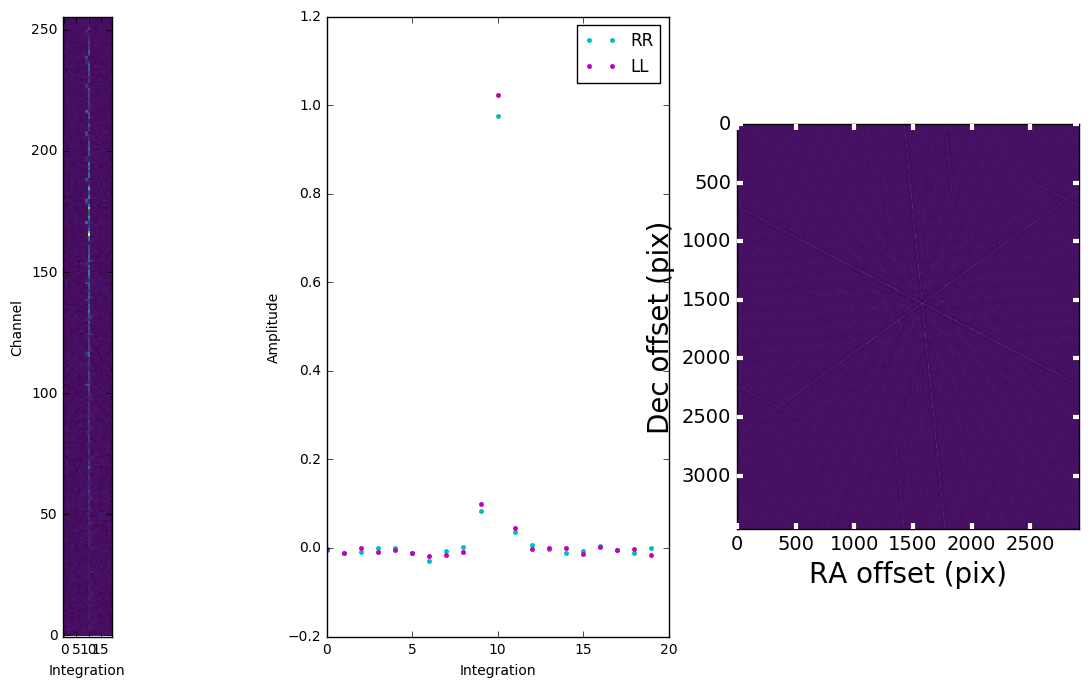

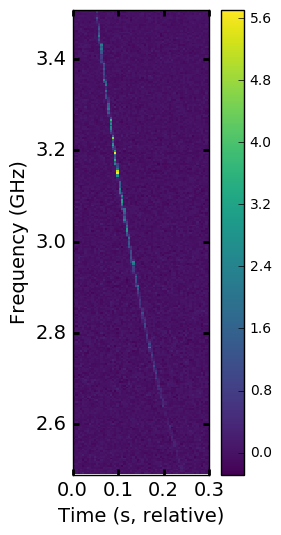

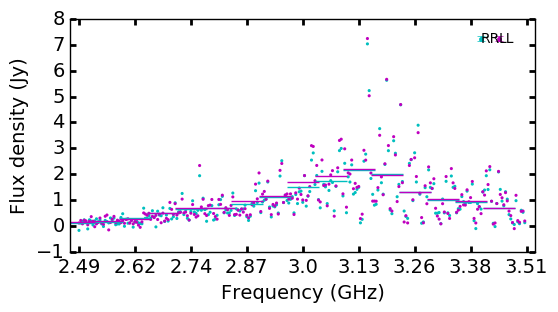

In [11]:
key = '57633_scan7'
st, data, u, v, w = read[key]
snrmax = find_dm(st, data, u, v, w)
dmmax[key] = snrmax
dm = snrmax[0]
integ = int(snrmax[1])
st['dmarr'] = [dm]
spectrum[key] = correct_and_plot(st, data, u, v, w, integ)
i0 = integ - 1
i1 = integ + 2
spectrumwide[key] = getwidespectrum(st, data, u, v, w, i0, i1)
print('Image SNR (orig): {0}'.format(snrdet[key]))

In [12]:
sdmfile = '16A-459_TEST_1hr_000.57633.66130137732.scan13.cut'
key = '57633_scan13'
scannum = getscannum(sdmfile)
read[key] = read_cut(sdmfile, scannum, 2, gainfile='16A-459_TEST_1hr_000.57633.66130137732.GN', npix_max=4096)

2016-12-27 07:29:30,167 - rtpipe.parsesdm - INFO - Setting (standard) key logfile to False
2016-12-27 07:29:30,168 - rtpipe.parsesdm - INFO - Setting (standard) key timesub to mean
2016-12-27 07:29:30,169 - rtpipe.parsesdm - INFO - Setting (standard) key gainfile to 16A-459_TEST_1hr_000.57633.66130137732.GN
2016-12-27 07:29:30,170 - rtpipe.parsesdm - INFO - Setting (standard) key dmarr to [558.0]
2016-12-27 07:29:30,171 - rtpipe.parsesdm - INFO - Setting (standard) key dtarr to [1]
2016-12-27 07:29:30,171 - rtpipe.parsesdm - INFO - Setting (standard) key npix_max to 4096
2016-12-27 07:29:30,172 - rtpipe.parsesdm - INFO - Setting (standard) key savecands to False
2016-12-27 07:29:30,173 - rtpipe.parsesdm - INFO - Setting (standard) key flaglist to [('badap', 3.0, 0.2)]
2016-12-27 07:29:30,174 - rtpipe.parsesdm - INFO - Setting (standard) key savenoise to False
2016-12-27 07:29:30,175 - rtpipe.parsesdm - INFO - Setting (standard) key flagantsol to True
2016-12-27 07:29:30,175 - rtpipe.pa

Scan 13 binary data file: /lustre/aoc/projects/16A-459/fastimaging/16A-459_TEST_1hr_000.57633.66130137732.scan13.cut/ASDMBinary/uid____evla_bdf_1472834169774


2016-12-27 07:29:30,487 - rtpipe.parsesdm - WARNING - No BDF found for scans [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14]
2016-12-27 07:29:30,563 - rtpipe.parsesdm - INFO - Calculating uvw for first integration of scan 13 of source FRB121102-off
2016-12-27 07:29:30,667 - rtpipe.parsesdm - INFO - 

2016-12-27 07:29:30,668 - rtpipe.parsesdm - INFO - Metadata summary:
2016-12-27 07:29:30,669 - rtpipe.parsesdm - INFO - 	 Working directory and data at /lustre/aoc/projects/16A-459/fastimaging, 16A-459_TEST_1hr_000.57633.66130137732.scan13.cut
2016-12-27 07:29:30,670 - rtpipe.parsesdm - INFO - 	 Using scan 13, source FRB121102-off
2016-12-27 07:29:30,671 - rtpipe.parsesdm - INFO - 	 nants, nbl: 27, 351
2016-12-27 07:29:30,671 - rtpipe.parsesdm - INFO - 	 Freq range (2.489 -- 3.509). 8 spw with 256 chans.
2016-12-27 07:29:30,672 - rtpipe.parsesdm - INFO - 	 Scan has 800 ints (4.0 s) and inttime 0.005 s
2016-12-27 07:29:30,673 - rtpipe.parsesdm - INFO - 	 2 polarizations: ['RR', 'LL']
2016-12-27

Gridded 1.000 of data. Scaling fft by = 51.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 51.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 51.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 51.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 51.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 51.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 51.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 51.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 51.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 51.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 51.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"
Gridded 1.

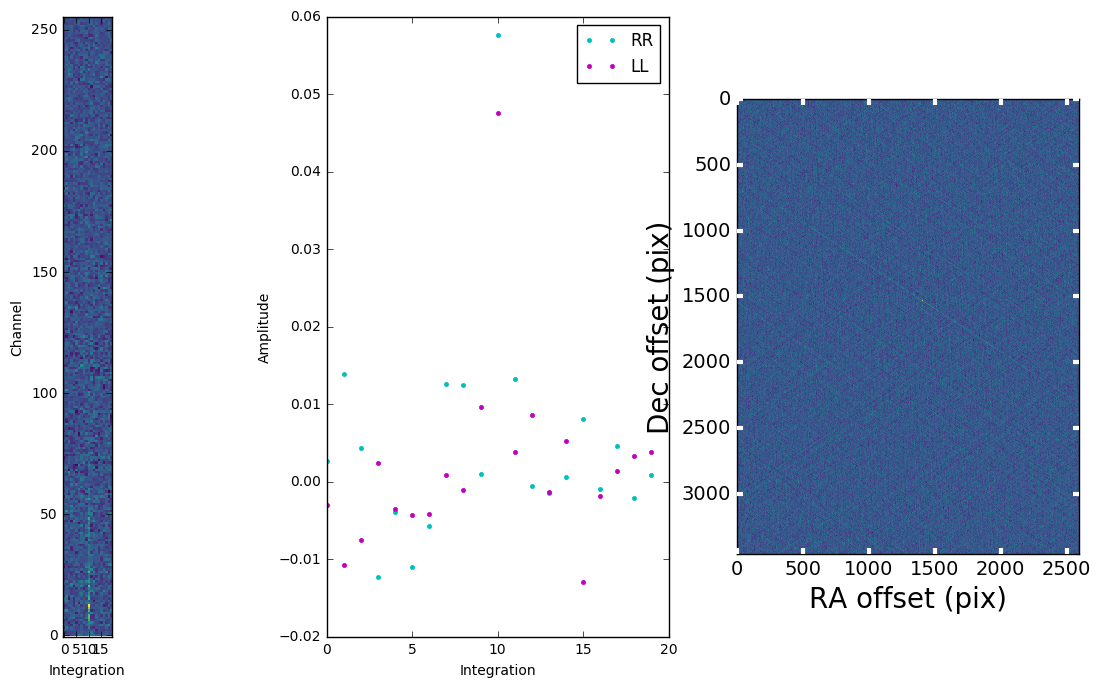

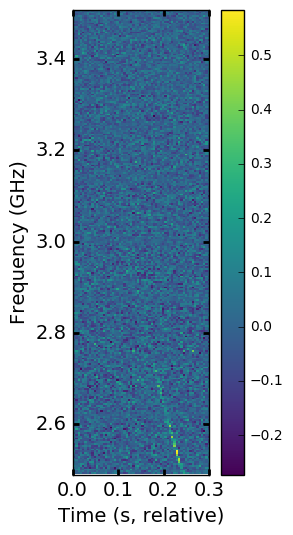

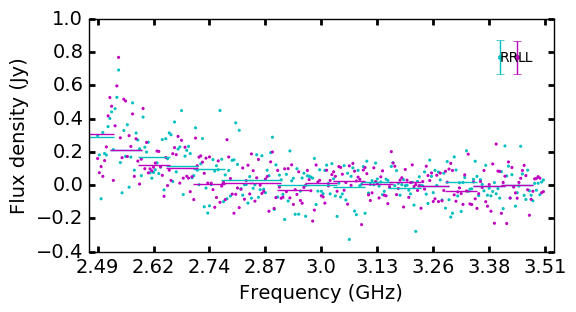

In [13]:
key = '57633_scan13'
st, data, u, v, w = read[key]
snrmax = find_dm(st, data, u, v, w)
dmmax[key] = snrmax
dm = snrmax[0]
integ = int(snrmax[1])
st['dmarr'] = [dm]
spectrum[key] = correct_and_plot(st, data, u, v, w, integ)
i0 = integ - 1
i1 = integ + 2
spectrumwide[key] = getwidespectrum(st, data, u, v, w, i0, i1)
print('Image SNR (orig): {0}'.format(snrdet[key]))

In [14]:
sdmfile = '16A-496_sb32698778_1_02h00m.57638.42695471065.cut'
key = '57638'
scannum = getscannum(sdmfile)
read[key] = read_cut(sdmfile, scannum, 4, npix_max=5500, chans=range(2,256))

2016-12-27 07:31:08,532 - rtpipe.parsesdm - INFO - Setting (standard) key logfile to False
2016-12-27 07:31:08,532 - rtpipe.parsesdm - INFO - Setting (standard) key timesub to mean
2016-12-27 07:31:08,533 - rtpipe.parsesdm - INFO - Setting (standard) key gainfile to 16A-496_sb32698778_1_02h00m.57638.42695471065.GN
2016-12-27 07:31:08,534 - rtpipe.parsesdm - INFO - Setting (standard) key dmarr to [558.0]
2016-12-27 07:31:08,535 - rtpipe.parsesdm - INFO - Setting (standard) key dtarr to [1]
2016-12-27 07:31:08,536 - rtpipe.parsesdm - INFO - Setting (standard) key chans to [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107

Scan 29 binary data file: /lustre/aoc/projects/16A-459/fastimaging/16A-496_sb32698778_1_02h00m.57638.42695471065.cut/ASDMBinary/uid____evla_bdf_1473249228150


2016-12-27 07:31:09,213 - rtpipe.parsesdm - WARNING - No BDF found for scans [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33]
2016-12-27 07:31:09,349 - rtpipe.parsesdm - INFO - Calculating uvw for first integration of scan 29 of source FRB121102-off
2016-12-27 07:31:09,506 - rtpipe.parsesdm - INFO - 

2016-12-27 07:31:09,507 - rtpipe.parsesdm - INFO - Metadata summary:
2016-12-27 07:31:09,508 - rtpipe.parsesdm - INFO - 	 Working directory and data at /lustre/aoc/projects/16A-459/fastimaging, 16A-496_sb32698778_1_02h00m.57638.42695471065.cut
2016-12-27 07:31:09,509 - rtpipe.parsesdm - INFO - 	 Using scan 29, source FRB121102-off
2016-12-27 07:31:09,510 - rtpipe.parsesdm - INFO - 	 nants, nbl: 26, 325
2016-12-27 07:31:09,510 - rtpipe.parsesdm - INFO - 	 Freq range (2.497 -- 3.509). 8 spw with 254 chans.
2016-12-27 07:31:09,511 - rtpipe.parsesdm - INFO - 	 Scan has 800 ints (4.0 s) and inttime 0.005 s
2016-12-27 07:31:

Gridded 1.000 of data. Scaling fft by = 127.3
Pixel sizes (1.1", 0.7"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 127.3
Pixel sizes (1.1", 0.7"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 127.3
Pixel sizes (1.1", 0.7"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 127.3
Pixel sizes (1.1", 0.7"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 127.3
Pixel sizes (1.1", 0.7"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 127.3
Pixel sizes (1.1", 0.7"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 127.3
Pixel sizes (1.1", 0.7"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 127.3
Pixel sizes (1.1", 0.7"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 127.3
Pixel sizes (1.1", 0.7"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 127.3
Pixel sizes (1.1", 0.7"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 127.3
Pixel sizes (1.1", 0.7"), Field size 1983.3"

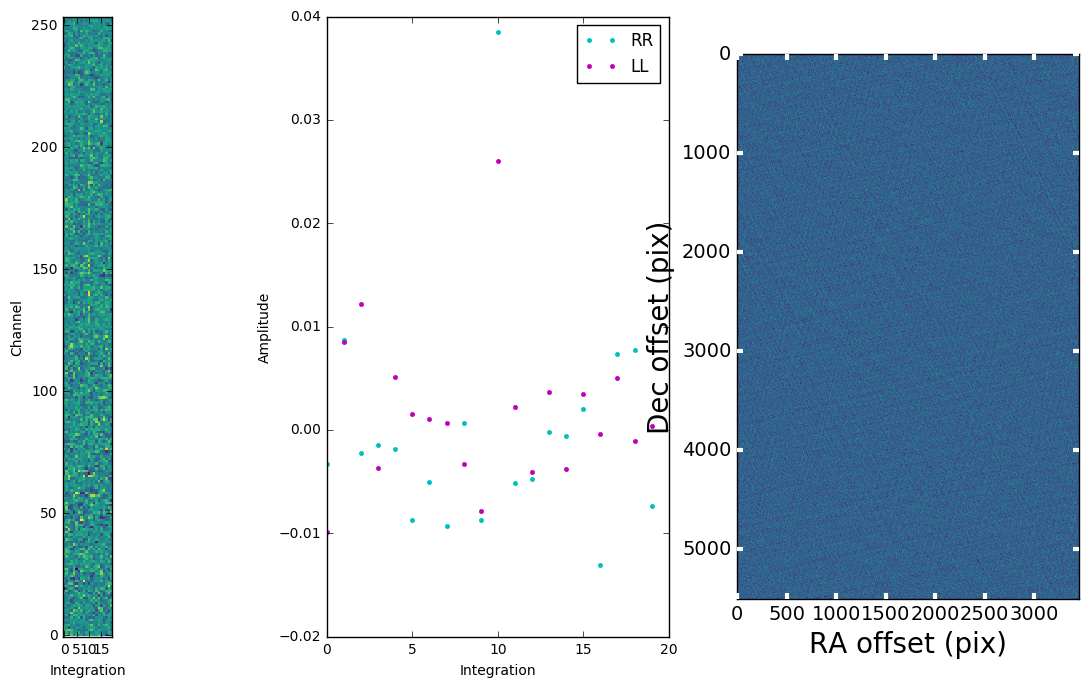

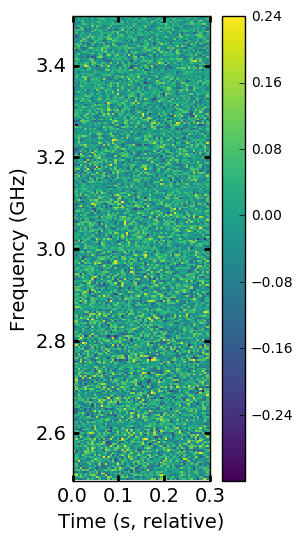

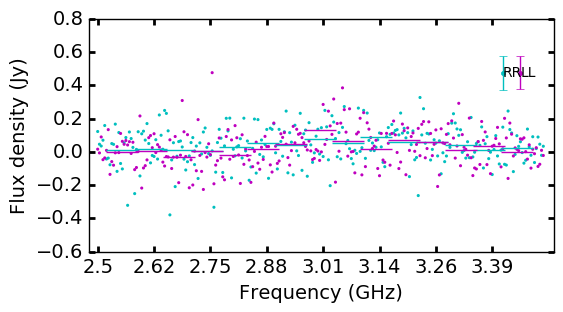

In [15]:
key = '57638'
st, data, u, v, w = read[key]
snrmax = find_dm(st, data, u, v, w)
dmmax[key] = snrmax
dm = snrmax[0]
integ = int(snrmax[1])
st['dmarr'] = [dm]
spectrum[key] = correct_and_plot(st, data, u, v, w, integ)
i0 = integ - 1
i1 = integ + 2
spectrumwide[key] = getwidespectrum(st, data, u, v, w, i0, i1)
print('Image SNR (orig): {0}'.format(snrdet[key]))

In [16]:
sdmfile = '16A-496_sb32698778_1_02h00m_001.57643.38562630787.cut/'
key = '57643'
scannum = getscannum(sdmfile)
read[key] = read_cut(sdmfile, scannum, 4, npix_max=5500)

2016-12-27 07:32:58,510 - rtpipe.parsesdm - INFO - Setting (standard) key logfile to False
2016-12-27 07:32:58,511 - rtpipe.parsesdm - INFO - Setting (standard) key timesub to mean
2016-12-27 07:32:58,512 - rtpipe.parsesdm - INFO - Setting (standard) key gainfile to 16A-496_sb32698778_1_02h00m_001.57643.38562630787.GN
2016-12-27 07:32:58,513 - rtpipe.parsesdm - INFO - Setting (standard) key dmarr to [558.0]
2016-12-27 07:32:58,514 - rtpipe.parsesdm - INFO - Setting (standard) key dtarr to [1]
2016-12-27 07:32:58,514 - rtpipe.parsesdm - INFO - Setting (standard) key npix_max to 5500
2016-12-27 07:32:58,515 - rtpipe.parsesdm - INFO - Setting (standard) key savecands to False
2016-12-27 07:32:58,516 - rtpipe.parsesdm - INFO - Setting (standard) key flaglist to [('badap', 3.0, 0.2)]
2016-12-27 07:32:58,517 - rtpipe.parsesdm - INFO - Setting (standard) key savenoise to False
2016-12-27 07:32:58,517 - rtpipe.parsesdm - INFO - Setting (standard) key flagantsol to True
2016-12-27 07:32:58,518 

Scan 29 binary data file: /lustre/aoc/projects/16A-459/fastimaging/16A-496_sb32698778_1_02h00m_001.57643.38562630787.cut/ASDMBinary/uid____evla_bdf_1473677657337


2016-12-27 07:32:59,025 - rtpipe.parsesdm - WARNING - No BDF found for scans [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33]
2016-12-27 07:32:59,154 - rtpipe.parsesdm - INFO - Calculating uvw for first integration of scan 29 of source FRB121102-off
2016-12-27 07:32:59,308 - rtpipe.parsesdm - INFO - 

2016-12-27 07:32:59,309 - rtpipe.parsesdm - INFO - Metadata summary:
2016-12-27 07:32:59,309 - rtpipe.parsesdm - INFO - 	 Working directory and data at /lustre/aoc/projects/16A-459/fastimaging, 16A-496_sb32698778_1_02h00m_001.57643.38562630787.cut
2016-12-27 07:32:59,310 - rtpipe.parsesdm - INFO - 	 Using scan 29, source FRB121102-off
2016-12-27 07:32:59,311 - rtpipe.parsesdm - INFO - 	 nants, nbl: 26, 325
2016-12-27 07:32:59,312 - rtpipe.parsesdm - INFO - 	 Freq range (2.489 -- 3.509). 8 spw with 256 chans.
2016-12-27 07:32:59,312 - rtpipe.parsesdm - INFO - 	 Scan has 800 ints (4.0 s) and inttime 0.005 s
2016-12-27 07

Gridded 1.000 of data. Scaling fft by = 180.2
Pixel sizes (0.9", 0.7"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 179.9
Pixel sizes (0.9", 0.7"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 180.0
Pixel sizes (0.9", 0.7"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 179.6
Pixel sizes (0.9", 0.7"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 180.1
Pixel sizes (0.9", 0.7"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 180.0
Pixel sizes (0.9", 0.7"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 179.8
Pixel sizes (0.9", 0.7"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 180.0
Pixel sizes (0.9", 0.7"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 179.8
Pixel sizes (0.9", 0.7"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 179.0
Pixel sizes (0.9", 0.7"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 178.9
Pixel sizes (0.9", 0.7"), Field size 1983.3"

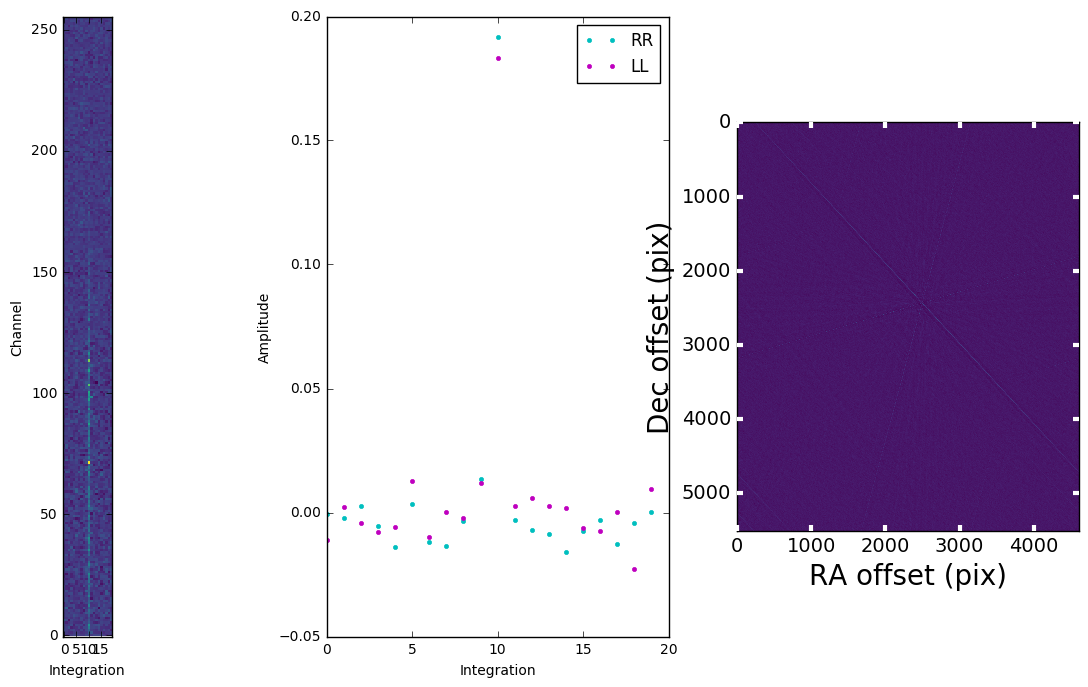

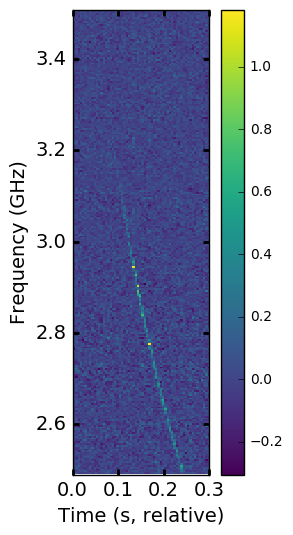

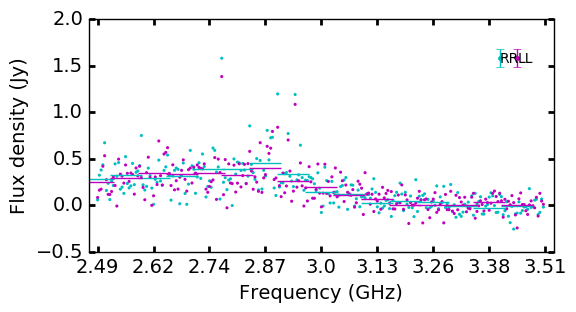

In [17]:
key = '57643'
st, data, u, v, w = read[key]
snrmax = find_dm(st, data, u, v, w)
dmmax[key] = snrmax
dm = snrmax[0]
integ = int(snrmax[1])
st['dmarr'] = [dm]
spectrum[key] = correct_and_plot(st, data, u, v, w, integ)
i0 = integ - 1
i1 = integ + 2
spectrumwide[key] = getwidespectrum(st, data, u, v, w, i0, i1)
print('Image SNR (orig): {0}'.format(snrdet[key]))

In [18]:
sdmfile = '16A-496_sb32698778_1_02h00m.57645.38915079861.cut'
key = '57645'
scannum = getscannum(sdmfile)
read[key] = read_cut(sdmfile, scannum, 6, npix_max=6500, chans=range(4,256))

2016-12-27 07:35:06,038 - rtpipe.parsesdm - INFO - Setting (standard) key logfile to False
2016-12-27 07:35:06,039 - rtpipe.parsesdm - INFO - Setting (standard) key timesub to mean
2016-12-27 07:35:06,039 - rtpipe.parsesdm - INFO - Setting (standard) key gainfile to 16A-496_sb32698778_1_02h00m.57645.38915079861.GN
2016-12-27 07:35:06,040 - rtpipe.parsesdm - INFO - Setting (standard) key dmarr to [558.0]
2016-12-27 07:35:06,041 - rtpipe.parsesdm - INFO - Setting (standard) key dtarr to [1]
2016-12-27 07:35:06,042 - rtpipe.parsesdm - INFO - Setting (standard) key chans to [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108,

Scan 16 binary data file: /lustre/aoc/projects/16A-459/fastimaging/16A-496_sb32698778_1_02h00m.57645.38915079861.cut/ASDMBinary/uid____evla_bdf_1473848163356


2016-12-27 07:35:06,573 - rtpipe.parsesdm - WARNING - No BDF found for scans [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
2016-12-27 07:35:06,706 - rtpipe.parsesdm - INFO - Calculating uvw for first integration of scan 16 of source FRB121102-off
2016-12-27 07:35:06,863 - rtpipe.parsesdm - INFO - 

2016-12-27 07:35:06,864 - rtpipe.parsesdm - INFO - Metadata summary:
2016-12-27 07:35:06,865 - rtpipe.parsesdm - INFO - 	 Working directory and data at /lustre/aoc/projects/16A-459/fastimaging, 16A-496_sb32698778_1_02h00m.57645.38915079861.cut
2016-12-27 07:35:06,865 - rtpipe.parsesdm - INFO - 	 Using scan 16, source FRB121102-off
2016-12-27 07:35:06,866 - rtpipe.parsesdm - INFO - 	 nants, nbl: 27, 351
2016-12-27 07:35:06,867 - rtpipe.parsesdm - INFO - 	 Freq range (2.505 -- 3.509). 8 spw with 252 chans.
2016-12-27 07:35:06,868 - rtpipe.parsesdm - INFO - 	 Scan has 800 ints (4.0 s) and inttime 0.005 s
2016-12-27 07:35:

Gridded 1.000 of data. Scaling fft by = 250.3
Pixel sizes (0.6", 0.6"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 250.3
Pixel sizes (0.6", 0.6"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 250.3
Pixel sizes (0.6", 0.6"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 250.3
Pixel sizes (0.6", 0.6"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 250.3
Pixel sizes (0.6", 0.6"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 250.3
Pixel sizes (0.6", 0.6"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 250.3
Pixel sizes (0.6", 0.6"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 250.3
Pixel sizes (0.6", 0.6"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 250.3
Pixel sizes (0.6", 0.6"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 250.3
Pixel sizes (0.6", 0.6"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 250.3
Pixel sizes (0.6", 0.6"), Field size 1983.3"

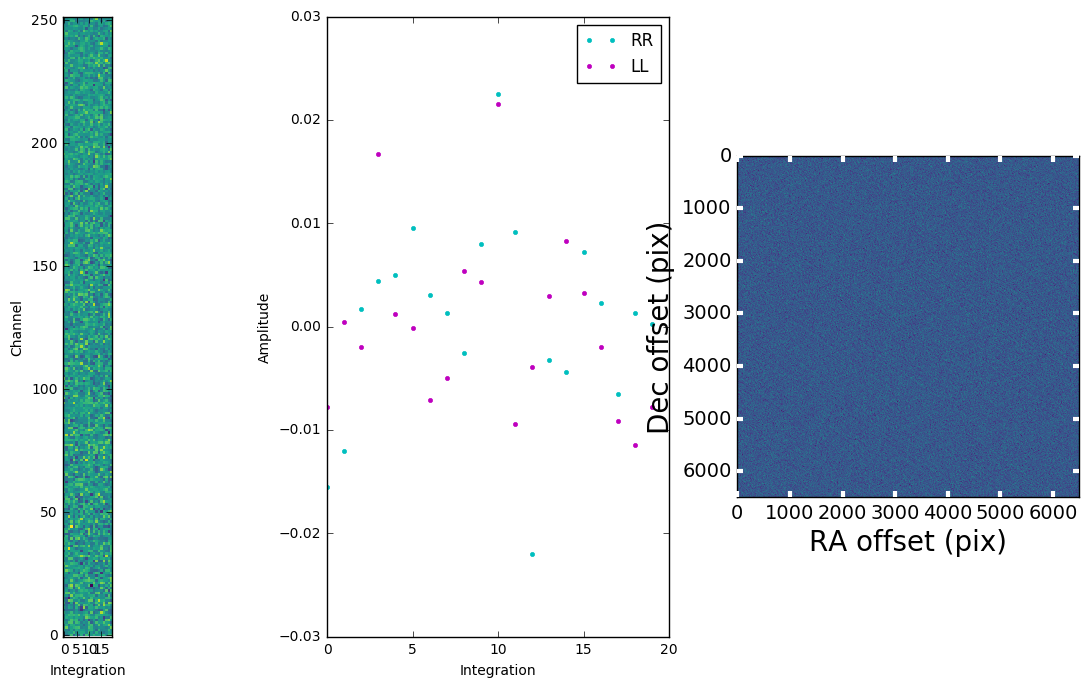

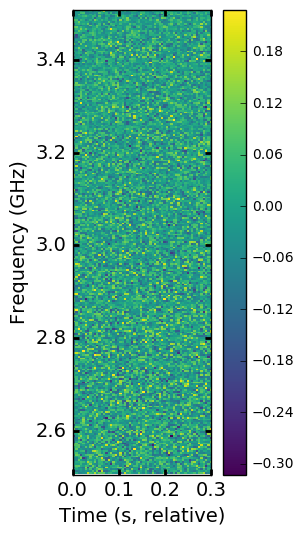

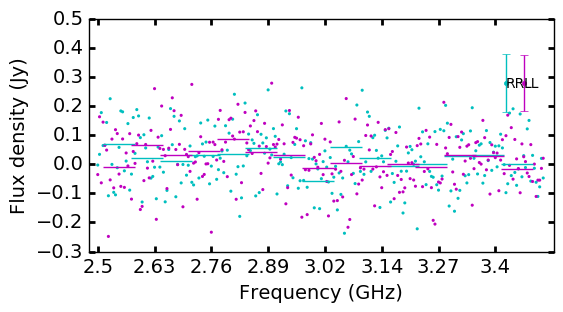

In [19]:
key = '57645'
st, data, u, v, w = read[key]
snrmax = find_dm(st, data, u, v, w)
dmmax[key] = snrmax
dm = snrmax[0]
integ = int(snrmax[1])
st['dmarr'] = [dm]
spectrum[key] = correct_and_plot(st, data, u, v, w, integ)
i0 = integ - 1
i1 = integ + 2
spectrumwide[key] = getwidespectrum(st, data, u, v, w, i0, i1)
print('Image SNR (orig): {0}'.format(snrdet[key]))

In [20]:
sdmfile = '16A-496_sb32698778_1_02h00m_000.57646.38643644676.cut'
key = '57646'
scannum = getscannum(sdmfile)
read[key] = read_cut(sdmfile, scannum, 6, npix_max=7000, chans=range(3,256))

2016-12-27 07:38:03,453 - rtpipe.parsesdm - INFO - Setting (standard) key logfile to False
2016-12-27 07:38:03,454 - rtpipe.parsesdm - INFO - Setting (standard) key timesub to mean
2016-12-27 07:38:03,455 - rtpipe.parsesdm - INFO - Setting (standard) key gainfile to 16A-496_sb32698778_1_02h00m_000.57646.38643644676.GN
2016-12-27 07:38:03,456 - rtpipe.parsesdm - INFO - Setting (standard) key dmarr to [558.0]
2016-12-27 07:38:03,456 - rtpipe.parsesdm - INFO - Setting (standard) key dtarr to [1]
2016-12-27 07:38:03,457 - rtpipe.parsesdm - INFO - Setting (standard) key chans to [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 10

Scan 32 binary data file: /lustre/aoc/projects/16A-459/fastimaging/16A-496_sb32698778_1_02h00m_000.57646.38643644676.cut/ASDMBinary/uid____evla_bdf_1473937600955


2016-12-27 07:38:03,980 - rtpipe.parsesdm - WARNING - No BDF found for scans [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33]
2016-12-27 07:38:04,111 - rtpipe.parsesdm - INFO - Calculating uvw for first integration of scan 32 of source FRB121102-off
2016-12-27 07:38:04,267 - rtpipe.parsesdm - INFO - 

2016-12-27 07:38:04,268 - rtpipe.parsesdm - INFO - Metadata summary:
2016-12-27 07:38:04,268 - rtpipe.parsesdm - INFO - 	 Working directory and data at /lustre/aoc/projects/16A-459/fastimaging, 16A-496_sb32698778_1_02h00m_000.57646.38643644676.cut
2016-12-27 07:38:04,269 - rtpipe.parsesdm - INFO - 	 Using scan 32, source FRB121102-off
2016-12-27 07:38:04,270 - rtpipe.parsesdm - INFO - 	 nants, nbl: 27, 351
2016-12-27 07:38:04,271 - rtpipe.parsesdm - INFO - 	 Freq range (2.501 -- 3.509). 8 spw with 253 chans.
2016-12-27 07:38:04,271 - rtpipe.parsesdm - INFO - 	 Scan has 800 ints (4.0 s) and inttime 0.005 s
2016-12-27 07

Gridded 1.000 of data. Scaling fft by = 304.7
Pixel sizes (0.6", 0.6"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 304.4
Pixel sizes (0.6", 0.6"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 304.7
Pixel sizes (0.6", 0.6"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 304.6
Pixel sizes (0.6", 0.6"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 304.6
Pixel sizes (0.6", 0.6"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 304.7
Pixel sizes (0.6", 0.6"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 304.8
Pixel sizes (0.6", 0.6"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 302.8
Pixel sizes (0.6", 0.6"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 302.7
Pixel sizes (0.6", 0.6"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 303.1
Pixel sizes (0.6", 0.6"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 302.9
Pixel sizes (0.6", 0.6"), Field size 1983.3"

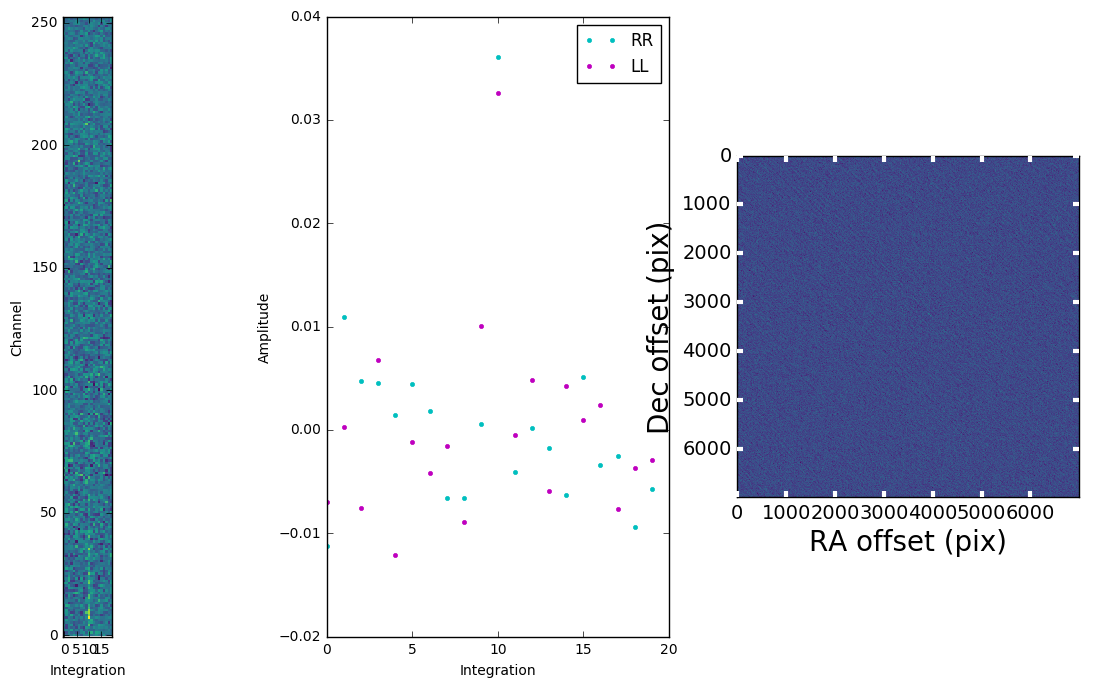

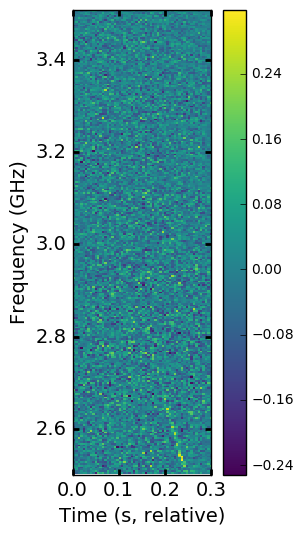

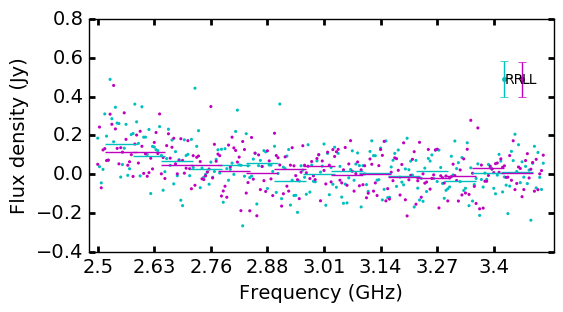

In [21]:
key = '57646'
st, data, u, v, w = read[key]
snrmax = find_dm(st, data, u, v, w)
dmmax[key] = snrmax
dm = snrmax[0]
integ = int(snrmax[1])
st['dmarr'] = [dm]
spectrum[key] = correct_and_plot(st, data, u, v, w, integ)
i0 = integ - 1
i1 = integ + 2
spectrumwide[key] = getwidespectrum(st, data, u, v, w, i0, i1)
print('Image SNR (orig): {0}'.format(snrdet[key]))

In [22]:
sdmfile = '16A-496_sb32698778_1_02h00m_000.57648.37452900463.cut/'
key = '57648'
scannum = getscannum(sdmfile)
read[key] = read_cut(sdmfile, scannum, 7, npix_max=7400, chans=range(2,256))

2016-12-27 07:41:09,909 - rtpipe.parsesdm - INFO - Setting (standard) key logfile to False
2016-12-27 07:41:09,909 - rtpipe.parsesdm - INFO - Setting (standard) key timesub to mean
2016-12-27 07:41:09,910 - rtpipe.parsesdm - INFO - Setting (standard) key gainfile to 16A-496_sb32698778_1_02h00m_000.57648.37452900463.GN
2016-12-27 07:41:09,911 - rtpipe.parsesdm - INFO - Setting (standard) key dmarr to [558.0]
2016-12-27 07:41:09,912 - rtpipe.parsesdm - INFO - Setting (standard) key dtarr to [1]
2016-12-27 07:41:09,912 - rtpipe.parsesdm - INFO - Setting (standard) key chans to [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106,

Scan 25 binary data file: /lustre/aoc/projects/16A-459/fastimaging/16A-496_sb32698778_1_02h00m_000.57648.37452900463.cut/ASDMBinary/uid____evla_bdf_1474107905881


2016-12-27 07:41:10,437 - rtpipe.parsesdm - WARNING - No BDF found for scans [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33]
2016-12-27 07:41:10,564 - rtpipe.parsesdm - INFO - Calculating uvw for first integration of scan 25 of source FRB121102-off
2016-12-27 07:41:10,716 - rtpipe.parsesdm - INFO - 

2016-12-27 07:41:10,717 - rtpipe.parsesdm - INFO - Metadata summary:
2016-12-27 07:41:10,717 - rtpipe.parsesdm - INFO - 	 Working directory and data at /lustre/aoc/projects/16A-459/fastimaging, 16A-496_sb32698778_1_02h00m_000.57648.37452900463.cut
2016-12-27 07:41:10,718 - rtpipe.parsesdm - INFO - 	 Using scan 25, source FRB121102-off
2016-12-27 07:41:10,719 - rtpipe.parsesdm - INFO - 	 nants, nbl: 27, 351
2016-12-27 07:41:10,720 - rtpipe.parsesdm - INFO - 	 Freq range (2.497 -- 3.509). 8 spw with 254 chans.
2016-12-27 07:41:10,720 - rtpipe.parsesdm - INFO - 	 Scan has 800 ints (4.0 s) and inttime 0.005 s
2016-12-27 07

Gridded 1.000 of data. Scaling fft by = 318.9
Pixel sizes (0.5", 0.5"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 318.9
Pixel sizes (0.5", 0.5"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 318.9
Pixel sizes (0.5", 0.5"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 318.9
Pixel sizes (0.5", 0.5"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 318.9
Pixel sizes (0.5", 0.5"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 318.9
Pixel sizes (0.5", 0.5"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 318.9
Pixel sizes (0.5", 0.5"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 318.9
Pixel sizes (0.5", 0.5"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 318.9
Pixel sizes (0.5", 0.5"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 318.9
Pixel sizes (0.5", 0.5"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 318.9
Pixel sizes (0.5", 0.5"), Field size 1983.3"

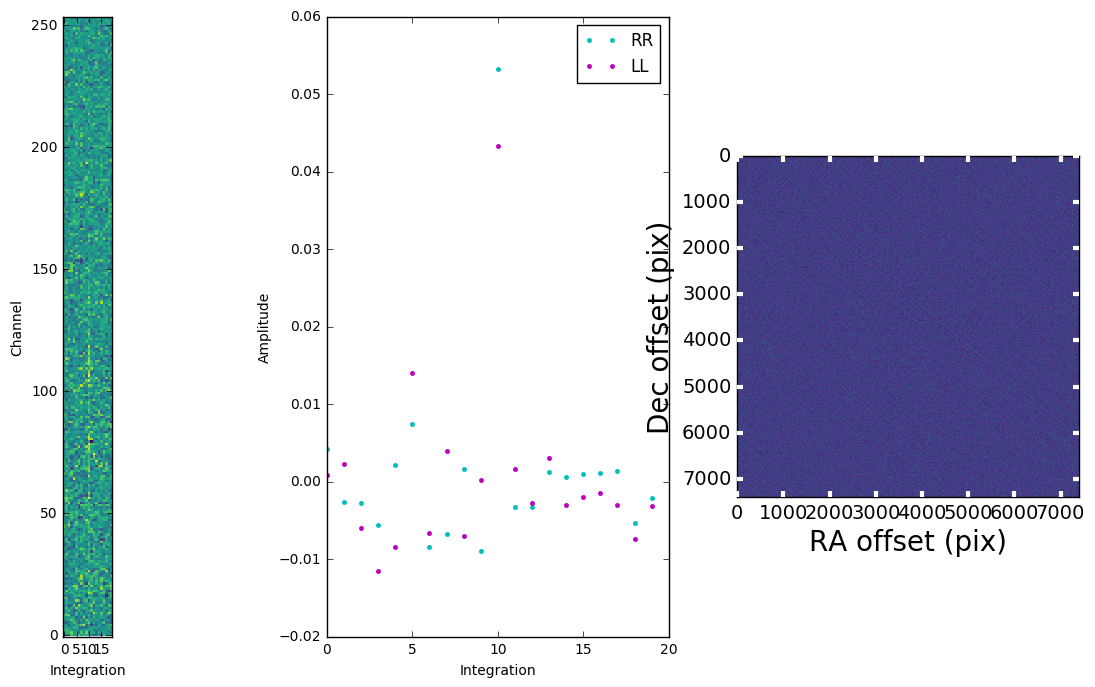

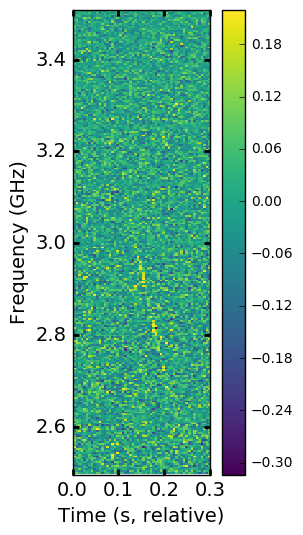

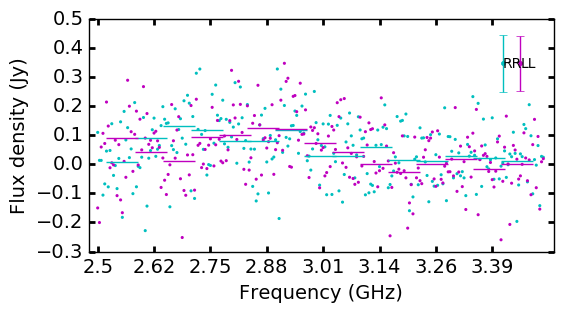

In [23]:
key = '57648'
st, data, u, v, w = read[key]
snrmax = find_dm(st, data, u, v, w)
dmmax[key] = snrmax
dm = snrmax[0]
integ = int(snrmax[1])
st['dmarr'] = [dm]
spectrum[key] = correct_and_plot(st, data, u, v, w, integ)
i0 = integ - 1
i1 = integ + 2
spectrumwide[key] = getwidespectrum(st, data, u, v, w, i0, i1)
print('Image SNR (orig): {0}'.format(snrdet[key]))

In [24]:
sdmfile = '16A-496_sb32698778_1_02h00m_001.57649.37461215278.cut/'
key = '57649'
scannum = getscannum(sdmfile)
read[key] = read_cut(sdmfile, scannum, 7, npix_max=7400)

2016-12-27 07:45:45,384 - rtpipe.parsesdm - INFO - Setting (standard) key logfile to False
2016-12-27 07:45:45,385 - rtpipe.parsesdm - INFO - Setting (standard) key timesub to mean
2016-12-27 07:45:45,386 - rtpipe.parsesdm - INFO - Setting (standard) key gainfile to 16A-496_sb32698778_1_02h00m_001.57649.37461215278.GN
2016-12-27 07:45:45,387 - rtpipe.parsesdm - INFO - Setting (standard) key dmarr to [558.0]
2016-12-27 07:45:45,387 - rtpipe.parsesdm - INFO - Setting (standard) key dtarr to [1]
2016-12-27 07:45:45,388 - rtpipe.parsesdm - INFO - Setting (standard) key npix_max to 7400
2016-12-27 07:45:45,389 - rtpipe.parsesdm - INFO - Setting (standard) key savecands to False
2016-12-27 07:45:45,389 - rtpipe.parsesdm - INFO - Setting (standard) key flaglist to [('badap', 3.0, 0.2)]
2016-12-27 07:45:45,390 - rtpipe.parsesdm - INFO - Setting (standard) key savenoise to False
2016-12-27 07:45:45,391 - rtpipe.parsesdm - INFO - Setting (standard) key flagantsol to True
2016-12-27 07:45:45,392 

Scan 31 binary data file: /lustre/aoc/projects/16A-459/fastimaging/16A-496_sb32698778_1_02h00m_001.57649.37461215278.cut/ASDMBinary/uid____evla_bdf_1474195554648


2016-12-27 07:45:45,908 - rtpipe.parsesdm - WARNING - No BDF found for scans [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33]
2016-12-27 07:45:46,036 - rtpipe.parsesdm - INFO - Calculating uvw for first integration of scan 31 of source FRB121102-off
2016-12-27 07:45:46,190 - rtpipe.parsesdm - INFO - 

2016-12-27 07:45:46,191 - rtpipe.parsesdm - INFO - Metadata summary:
2016-12-27 07:45:46,192 - rtpipe.parsesdm - INFO - 	 Working directory and data at /lustre/aoc/projects/16A-459/fastimaging, 16A-496_sb32698778_1_02h00m_001.57649.37461215278.cut
2016-12-27 07:45:46,193 - rtpipe.parsesdm - INFO - 	 Using scan 31, source FRB121102-off
2016-12-27 07:45:46,193 - rtpipe.parsesdm - INFO - 	 nants, nbl: 26, 325
2016-12-27 07:45:46,194 - rtpipe.parsesdm - INFO - 	 Freq range (2.489 -- 3.509). 8 spw with 256 chans.
2016-12-27 07:45:46,195 - rtpipe.parsesdm - INFO - 	 Scan has 800 ints (4.0 s) and inttime 0.005 s
2016-12-27 07

Gridded 1.000 of data. Scaling fft by = 342.2
Pixel sizes (0.5", 0.5"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 342.2
Pixel sizes (0.5", 0.5"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 342.2
Pixel sizes (0.5", 0.5"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 342.2
Pixel sizes (0.5", 0.5"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 342.2
Pixel sizes (0.5", 0.5"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 342.2
Pixel sizes (0.5", 0.5"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 342.2
Pixel sizes (0.5", 0.5"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 342.2
Pixel sizes (0.5", 0.5"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 342.2
Pixel sizes (0.5", 0.5"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 342.2
Pixel sizes (0.5", 0.5"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 342.2
Pixel sizes (0.5", 0.5"), Field size 1983.3"

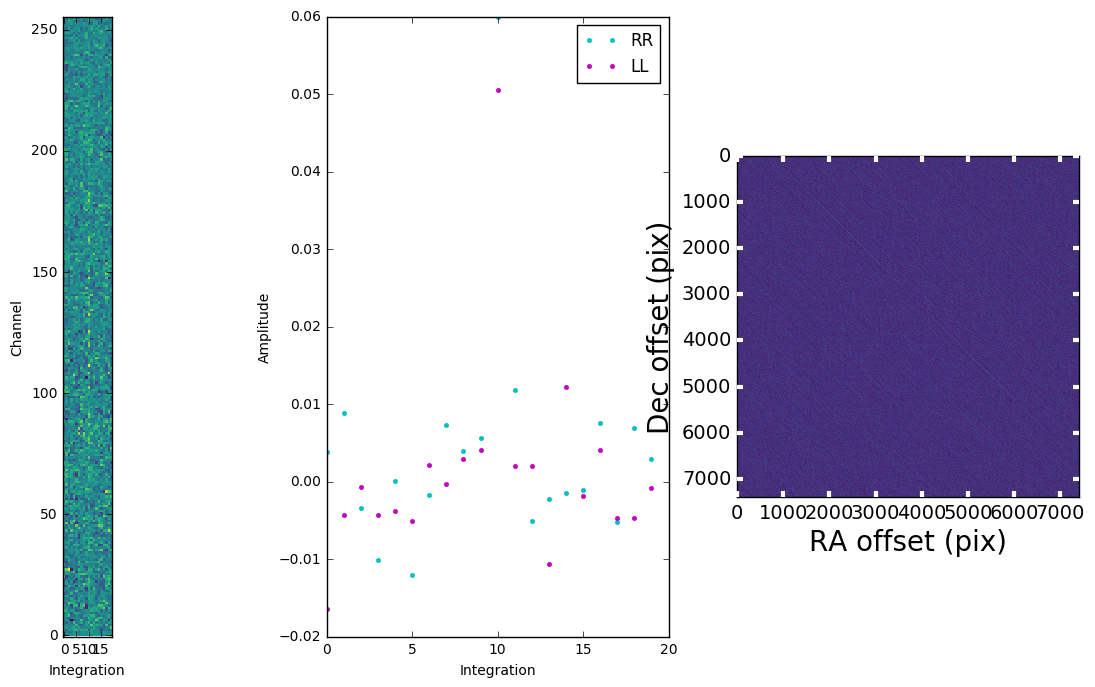

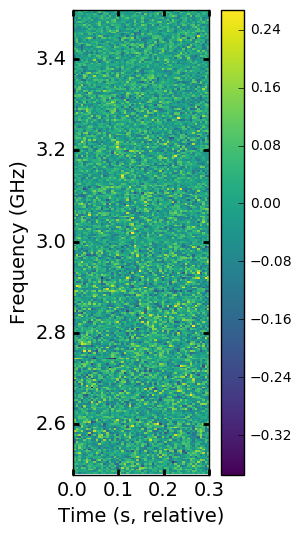

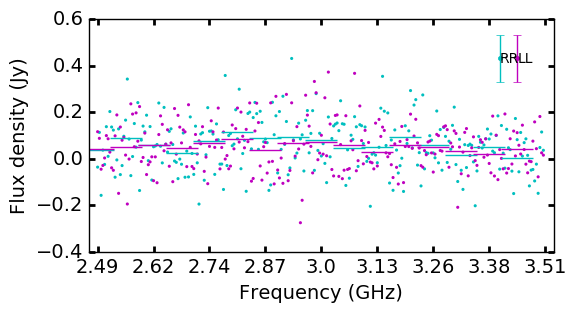

In [25]:
key = '57649'
st, data, u, v, w = read[key]
snrmax = find_dm(st, data, u, v, w)
dmmax[key] = snrmax
dm = snrmax[0]
integ = int(snrmax[1])
st['dmarr'] = [dm]
spectrum[key] = correct_and_plot(st, data, u, v, w, integ)
i0 = integ - 1
i1 = integ + 2
spectrumwide[key] = getwidespectrum(st, data, u, v, w, i0, i1)
print('Image SNR (orig): {0}'.format(snrdet[key]))

## Spectral autocorrelation

In [26]:
def plot_acf(st, data, u, v, w, integ):
    fig = pl.figure(figsize=(8,5))
    ax = fig.add_subplot(111)
    dataphdm = correct_all(st, data, u, v, w)
    spec = dataphdm[integ].mean(axis=2).mean(axis=0).real
    spec_off = dataphdm[integ+3].mean(axis=2).mean(axis=0).real
    ac = np.correlate(spec, spec, mode='same')
    ac_off = np.correlate(spec_off, spec_off, mode='same')
    pl.plot(ac, 'k.', label="Burst {0}".format(key))
    pl.plot(ac_off, 'c.', label="Off burst")   
    pl.xlabel('Delay (MHz)', fontsize=14)
    pl.ylabel('Autocorrelation power (Jy$^2$)', fontsize=14)
    xt = pl.setp(ax.get_xticklabels(), fontsize=14)
    yt = pl.setp(ax.get_yticklabels(), fontsize=14)
    ax.xaxis.set_tick_params(width=2, color='k')
    ax.yaxis.set_tick_params(width=2, color='k')
    pl.xticks(np.linspace(0, 256, 8), [str(int(4.0*(ch-128))) for ch in np.linspace(0, 256, 8)])
    pl.xlim(127.,256)
    pl.legend()

57633_scan7
57649
57638
57646
57633_scan13
57645
57648
57643
57623


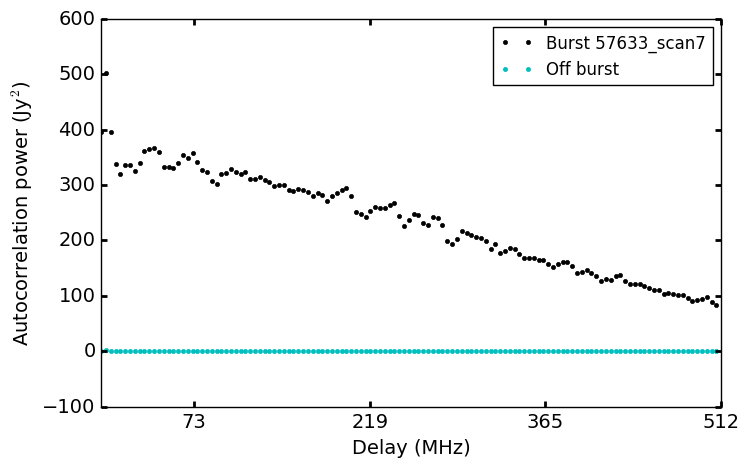

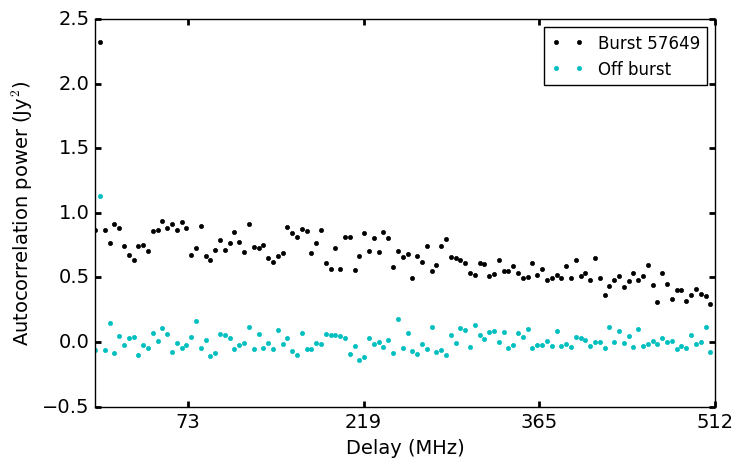

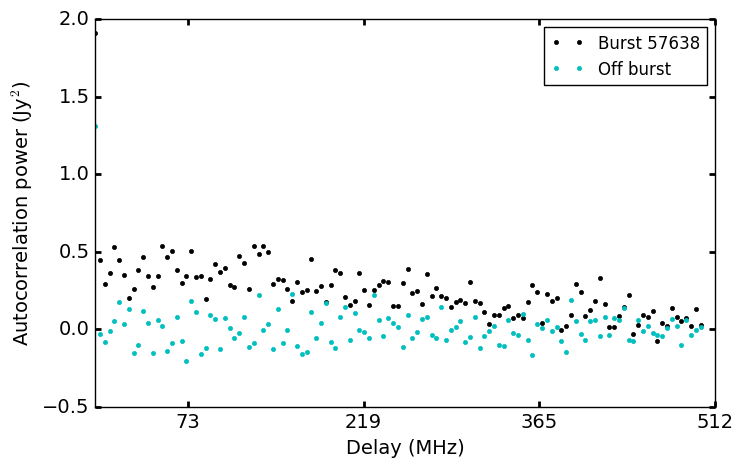

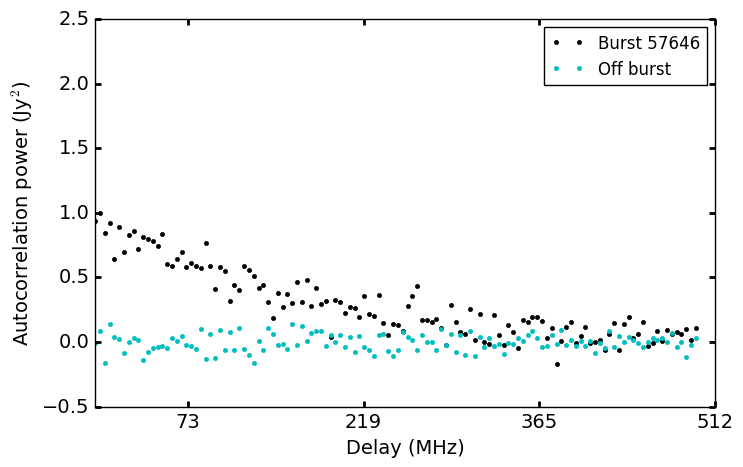

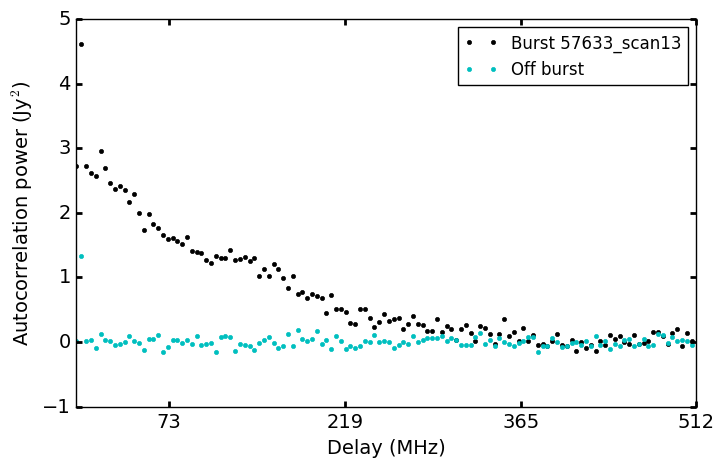

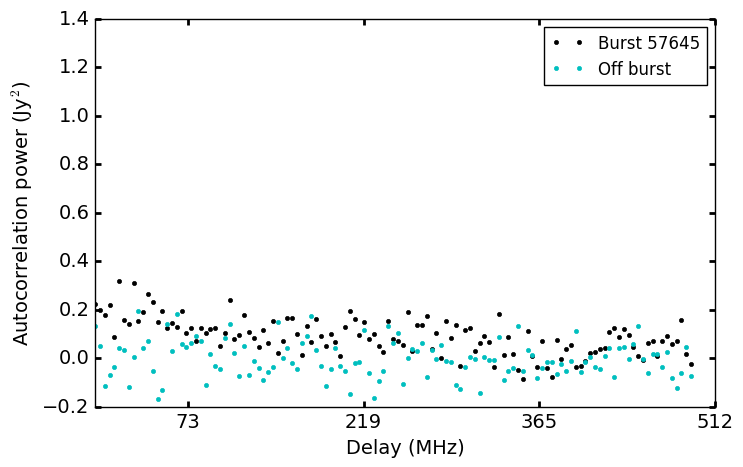

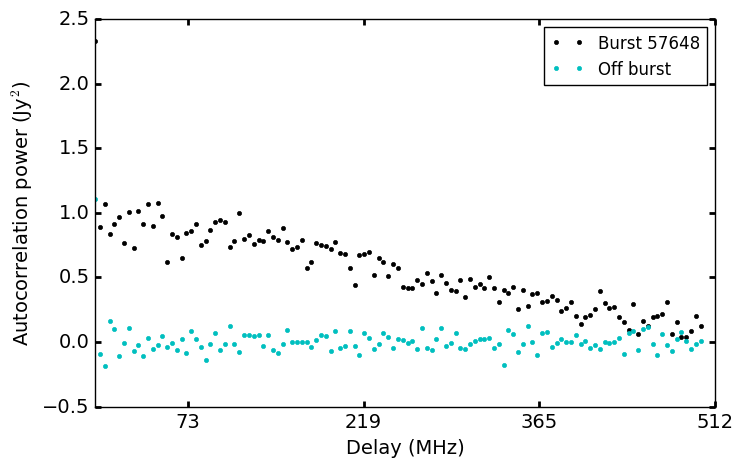

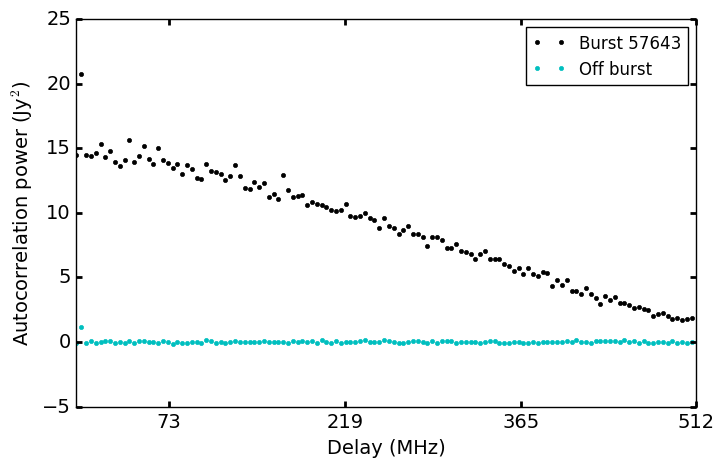

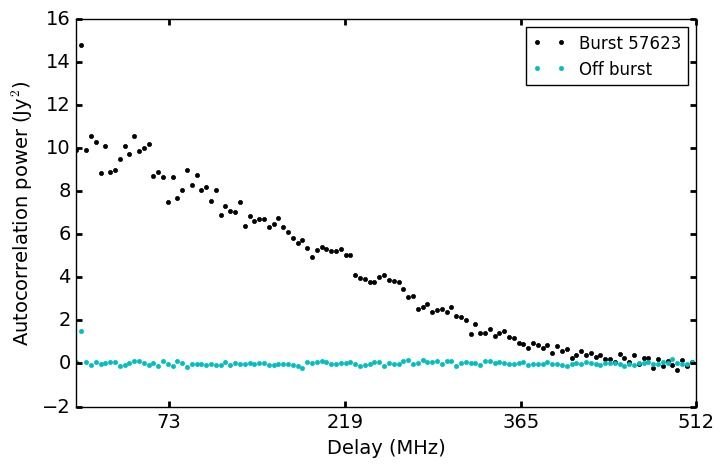

In [27]:
for key in snrdet.keys():
    print(key)
    integ = int(dmmax[key][1])
    st, data, u, v, w = read[key]
    plot_acf(st, data, u, v, w, integ)

## Spectrotemporal Modeling

In [28]:
import scipy.stats
from scipy.optimize import curve_fit

fbin = 4

sc = lambda sig: np.sqrt(2*sig**2*np.pi)
lum_s = lambda ld, s: s*1e-23 * (4*np.pi*ld**2) * 5e-3 * 1.024e9 # lum in erg, s in Jy, ld in cm
lum_ext = lambda ld, po: po[0]/sc(po[2])*1e-23 * (4*np.pi*ld**2) * 5e-3 * 2.355*fbin*4*po[2]*1e6 # lum in erg, s is norm fit peak in Jy, ld in cm

def norm(x, a, loc, scale):
    return a*scipy.stats.norm(loc, scale).pdf(x)

def fitandplot(spectrum, f0, popt_fixed=None, axis=()):

    # create binned spectrum
    nch0 = len(spectrum)
    spec = []
    for ch in range(0, nch0, fbin):
        spec.append(spectrum[ch:ch+fbin].mean())  # last bin may have fewer than 4 channels. go with it.
    spec = np.array(spec)
    nch = len(spec)
    print('Binned from {0} to {1} channels'.format(nch0, nch))
    
    if not popt_fixed:
        bounds = ([1, 0, 1], [2000, 256/fbin, 50])
        popt, pcov = curve_fit(norm, np.arange(nch), spec, bounds=bounds)
    else:
        popt = popt_fixed

    normsol = norm(np.linspace(0, nch, nch0), *popt)

    fig = pl.figure(figsize=(15,7))
    ax = fig.add_subplot(111)
#    pl.errorbar(range(fbin*nch), spectrum, fmt='c.', ecolor='c')
    pl.plot(range(nch0), spectrum, 'k.')
#    pl.plot(np.linspace(0, nch0, nch), spec, 'c*')
    pl.plot(np.arange(nch0), normsol, 'k')
    if len(axis):
        pl.axis(axis)
    pl.xlabel('Frequency (GHz)', fontsize=14)
    pl.ylabel('Flux density (Jy)', fontsize=14)
    pl.xlim(-4, nch0+4)
    pl.xticks(range(0, nch0+1, 32), [str(np.round(f0+ch*0.004, 2)) for ch in range(0, nch0+1, 32)])
    xt = pl.setp(ax.get_xticklabels(), fontsize=14)
    yt = pl.setp(ax.get_yticklabels(), fontsize=14)
    ax.xaxis.set_tick_params(width=2, color='k')
    ax.yaxis.set_tick_params(width=2, color='k')

    return popt


In [29]:
# full-res spectral fits
#popt = {'57623': [ 33.18660225 , 68.6786758  , 31.97989185],
#        '57633_scan7': [ 261.01468348,  163.37613653 ,  54.94315806],
#        '57633_scan13': [ 25.91234327 ,  0. , 36.83456147],
#        '57643': [ 54.70339027 , 68.70560927,  55.53711055],
#        '57649': [17.31563655, 104.88902813 ,  93.62882441],
#        '57638': [8.03104856,  159.12796452,   43.9087101 ],
#        '57646': [1.67436907e+01, 0.,  4.26219468e+01],
#        '57645': [3.63342113,  85.9990355,   22.58927418],
#        '57648': [ 12.25215549,  87.65698285,  44.20621731]}

# bin spectra by 4
popt = {'57633_scan7': [ 65.34364137,  40.53096697,  13.78088794],
       '57649': [  4.3092322,   25.87960046,  23.20757215],
       '57643': [ 13.77221702,  16.65750292,  13.9484172 ],
       '57638': [  2.02851581,  39.29549388,  11.28088088],
       '57646': [  3.98608102e+00, 0,   1.00213376e+01],
       '57633_scan13': [  6.40875573e+00,   0,   9.26735728e+00],
       '57645': [  1.17831665, 17.02810437,   9.24786317],
       '57648': [  3.05757414,  21.54651779, 11.21822984],
       '57623': [  8.30028279,  16.80016577 ,  8.00799541]}

57623
Binned from 256 to 64 channels
Already fit 57623 (peak, center, fwhm): 0.41 & 2.8 & 302
Energy: 7.12e+38
57633_scan13
Binned from 256 to 64 channels
Already fit 57633_scan13 (peak, center, fwhm): 0.28 & 2.5 & 349
Energy: 5.50e+38
57633_scan7
Binned from 256 to 64 channels
Already fit 57633_scan7 (peak, center, fwhm): 1.89 & 3.1 & 519
Energy: 5.60e+39
57638
Binned from 254 to 64 channels
Already fit 57638 (peak, center, fwhm): 0.07 & 3.1 & 425
Energy: 1.74e+38
57643
Binned from 256 to 64 channels
Already fit 57643 (peak, center, fwhm): 0.39 & 2.8 & 526
Energy: 1.18e+39
57645
Binned from 252 to 63 channels
Already fit 57645 (peak, center, fwhm): 0.05 & 2.8 & 348
Energy: 1.01e+38
57646
Binned from 253 to 64 channels
Already fit 57646 (peak, center, fwhm): 0.16 & 2.5 & 378
Energy: 3.42e+38
57648
Binned from 254 to 64 channels
Already fit 57648 (peak, center, fwhm): 0.11 & 2.8 & 423
Energy: 2.62e+38
57649
Binned from 256 to 64 channels
Already fit 57649 (peak, center, fwhm): 0.07 & 2.

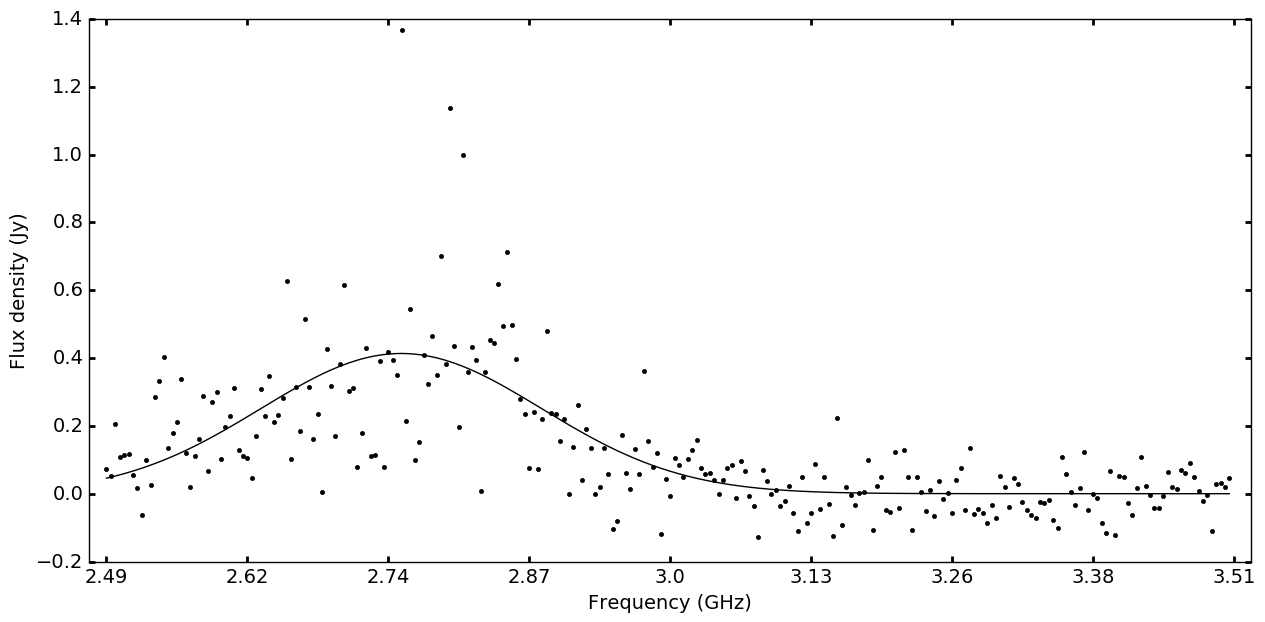

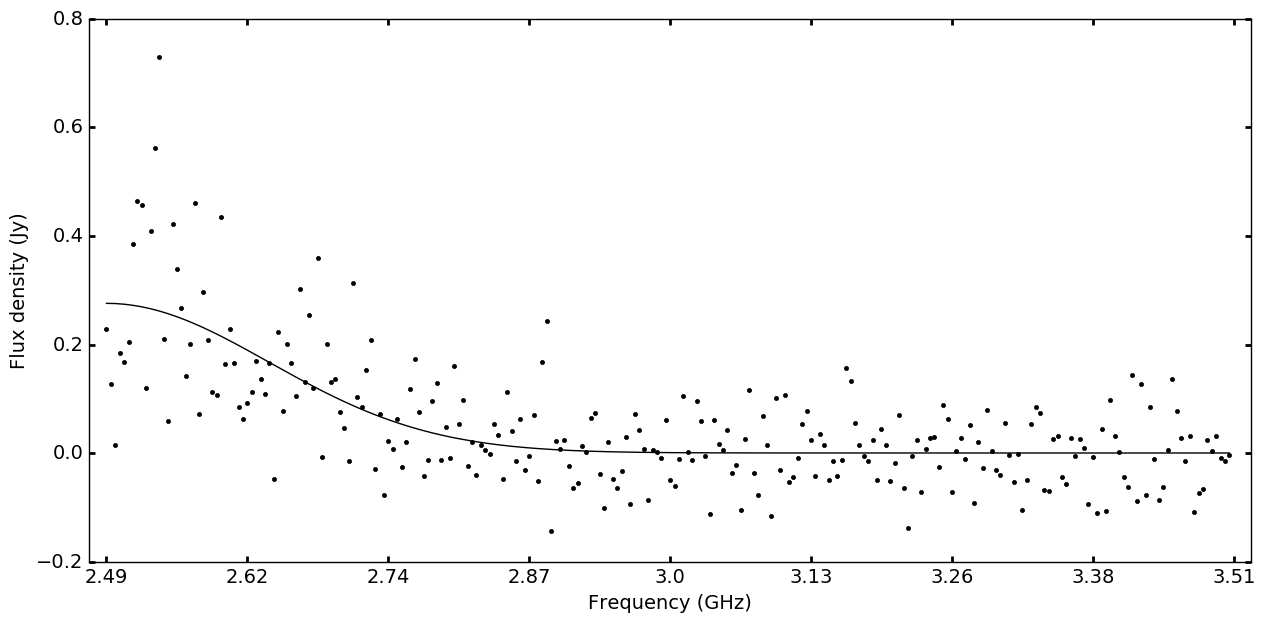

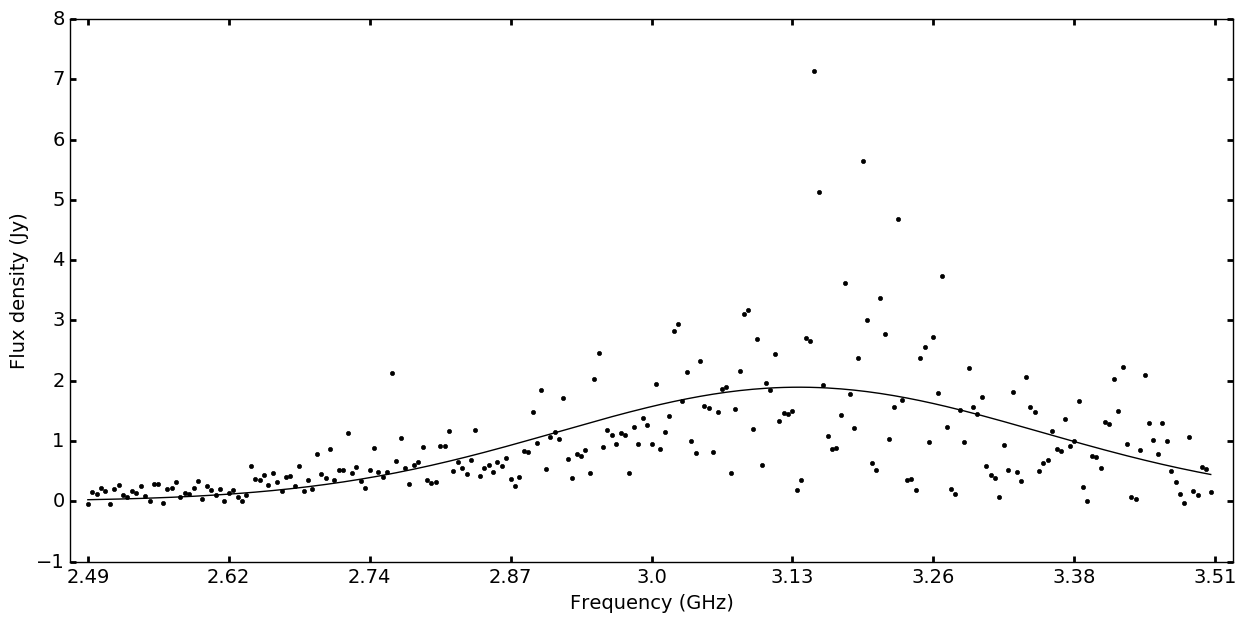

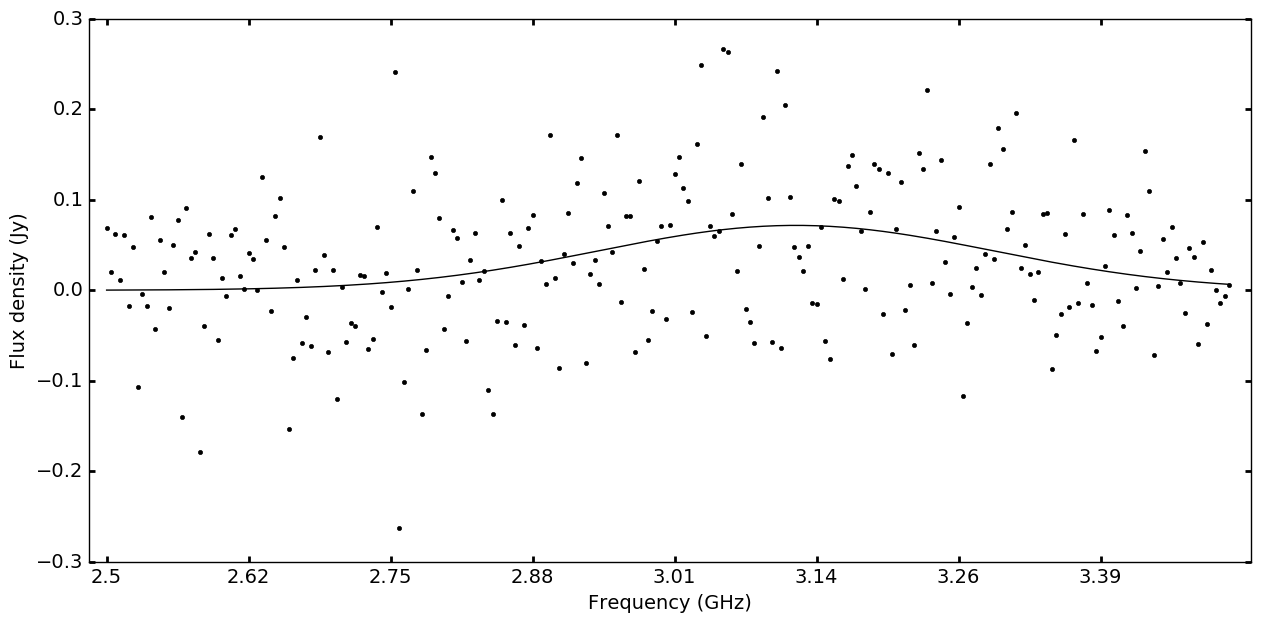

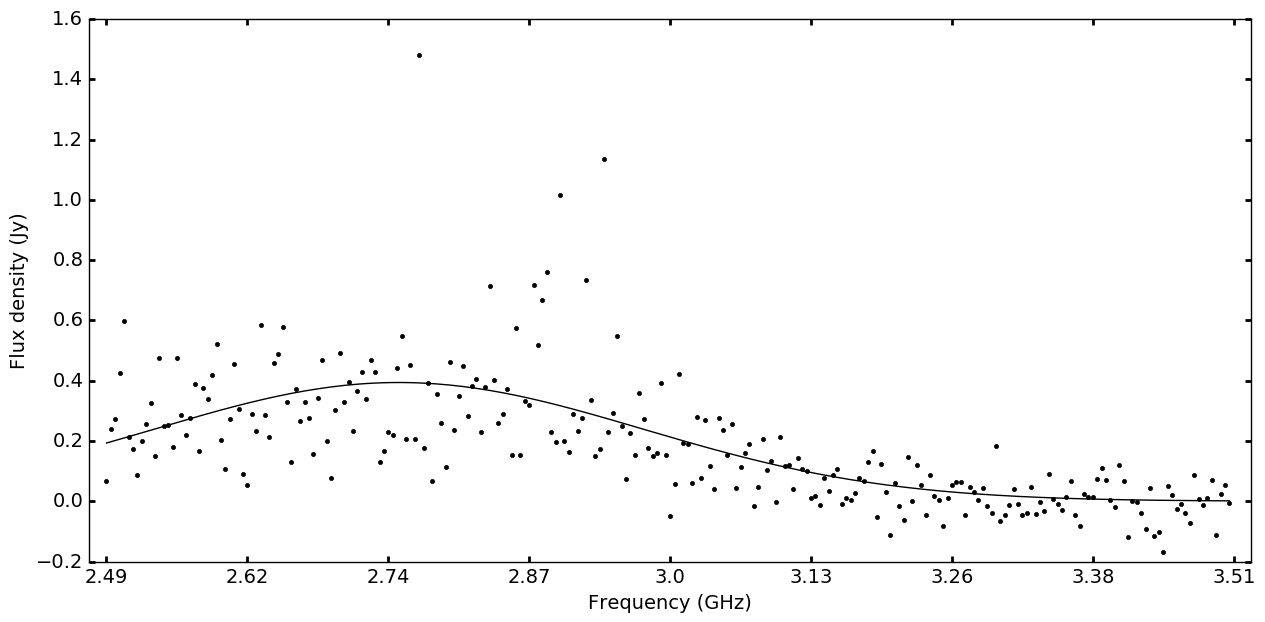

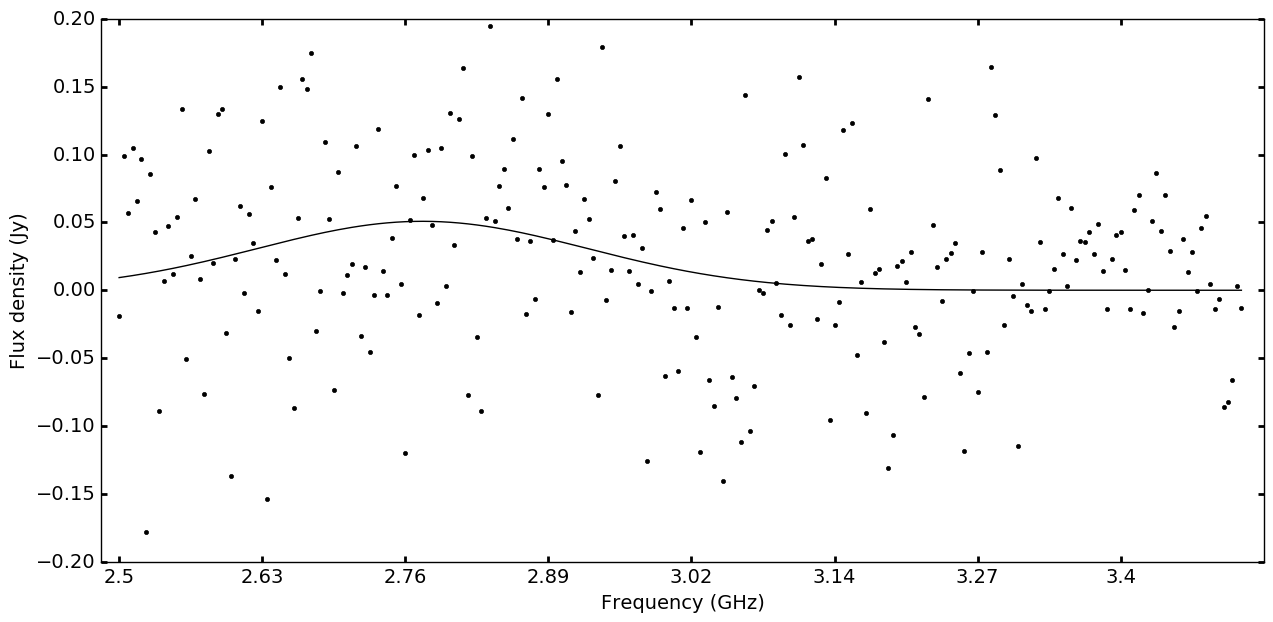

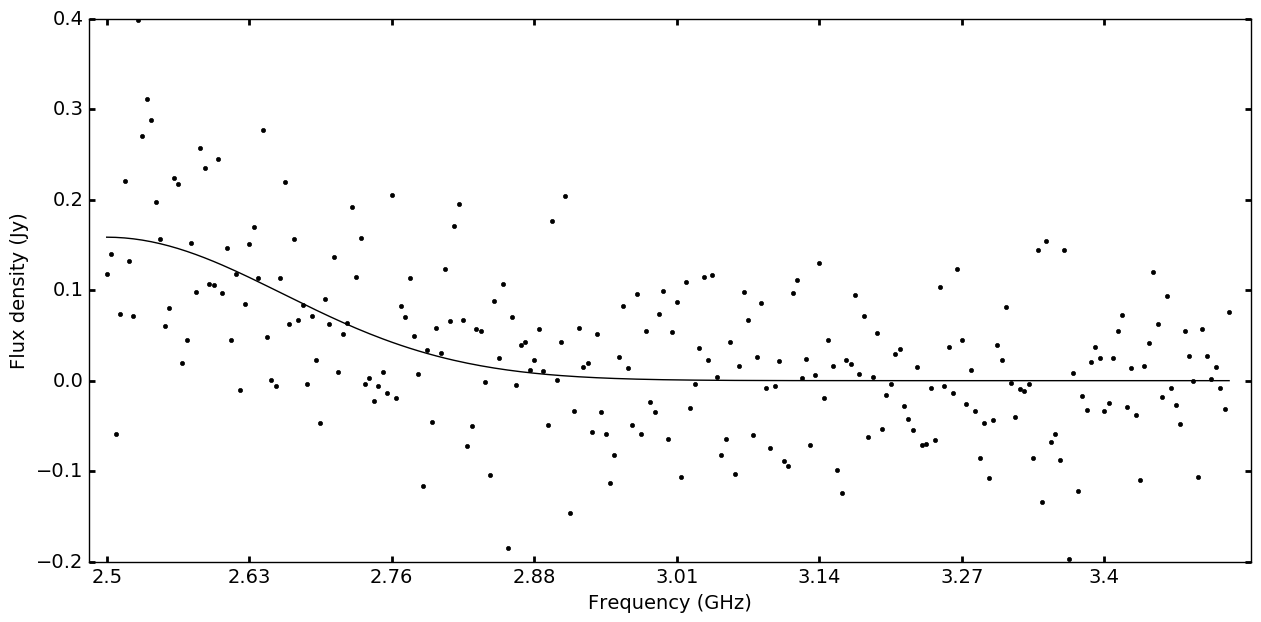

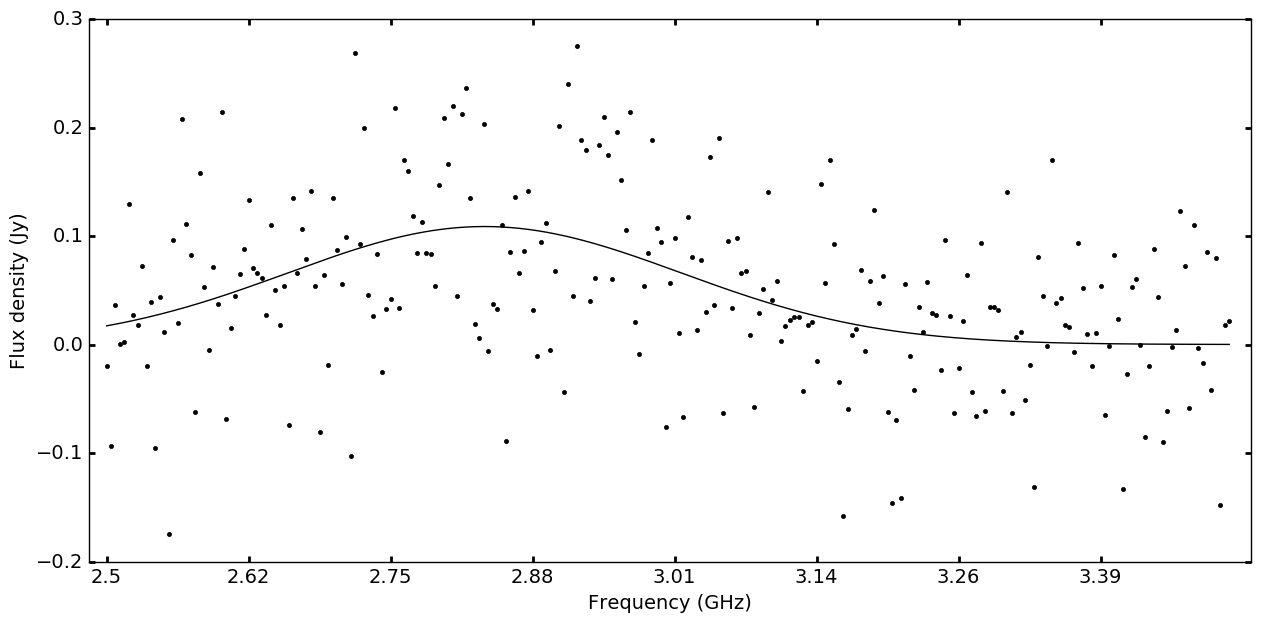

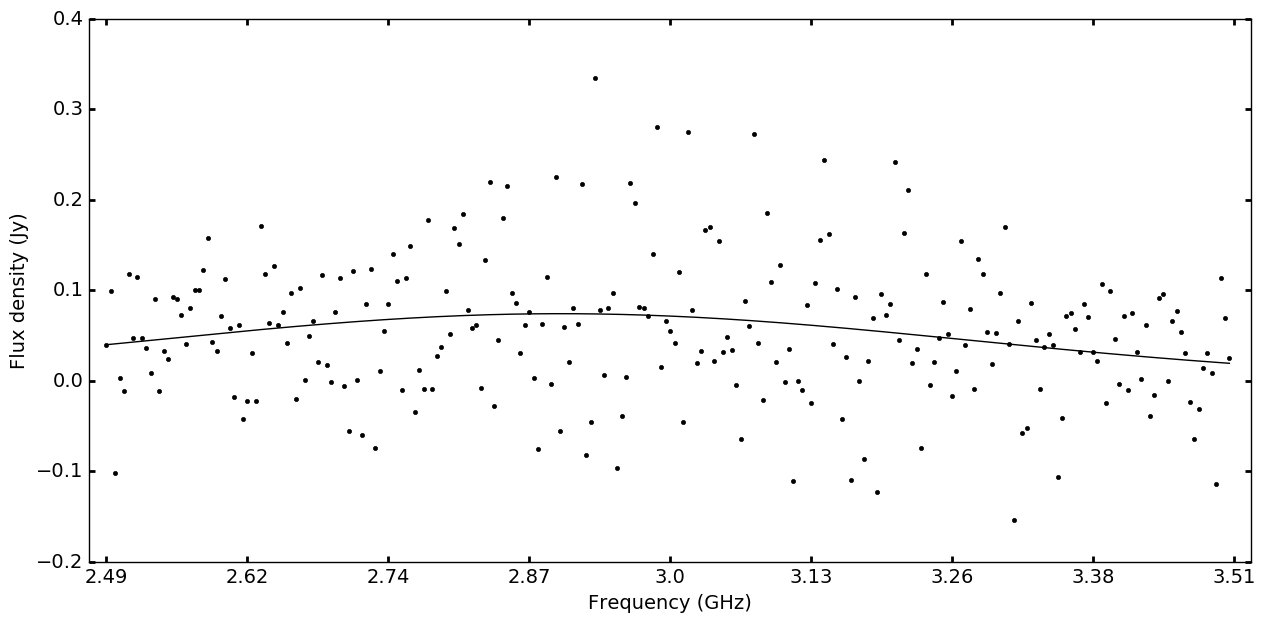

In [30]:
for key in sorted(snrdet.keys()):
    print(key)
    st, data, u, v, w = read[key]
    spec = spectrum[key].mean(axis=1)
    if key not in popt:
        po = fitandplot(spec, st['freq'][0])
        print(po)
        print('Fitting {0} (peak, center, fwhm): {1:.2f} & {2:.1f} & {3:.0f}'.format(key,
                                                                                  po[0]/sc(po[2]),
                                                                                  2.5+fbin*0.004*po[1],
                                                                                  np.round(2.355*fbin*4*po[2])), 2)
        break
    else:
        fitandplot(spec, st['freq'][0], popt_fixed=popt[key])
        po = popt[key]
        print('Already fit {0} (peak, center, fwhm): {1:.2f} & {2:.1f} & {3:.0f}'.format(key,
                                                                                  po[0]/sc(po[2]),
                                                                                  2.5+fbin*0.004*po[1],
                                                                                  np.round(2.355*fbin*4*po[2]), 2))
        print('Energy: {:1.2e}'.format(lum_ext(972e6*3.1e18, po)))

## Generative model of dispersion

In [31]:
def madstd(sgram, imax):
    return np.ma.median(np.ma.abs(sgram[:,:imax] - np.ma.median(sgram[:,:imax])))/0.67

def sample(sgram, spmod, freq, times, dms, indexes=[2], breakpoint=None):
    ny, nx = sgram.shape
    grid = np.zeros(shape=(len(times), len(dms), len(indexes)))
    std = madstd(sgram, times.min())
    print('Noise from MAD: {0}'.format(std))
    if breakpoint:
        ist, jst, kst = breakpoint
    else:
         ist, jst, kst = -1, -1, -1
        
    for i in range(len(times)):
        for j in range(len(dms)):
            for k in range(len(indexes)):
                model = genmodel(ny, nx, spmod, times[i], dms[j], freq, std, index=indexes[k])
#                diff = (sgram - model)/std  # use statistical error in measurement if using data as model
                diff = (sgram - model)/np.where(model < std, std, model)   # use scintillation "error" in spectrum
#                exp = rescale*np.exp(-(diff**2)/2)
#                grid[i,j,k] = np.ma.prod(np.ma.masked_where(model == 0, exp))
                grid[i,j,k] = np.ma.sum(np.ma.masked_where(model == 0, -(diff**2)/2))
                if k == kst:
                    break
            if j == jst:
                break
        if i == ist:
            break
    
    if breakpoint:
        print(i, j, k, times[i], dms[j], indexes[k])
        return exp
    else:
        return np.exp(grid-grid.max())
    
def genmodel(ny, nx, spmod, i0, dm, freq, std, index=2, dx=0.005):
    """ Generate a 2d model of a dispersed pulse """
    
#    model = np.random.normal(0, std, size=(ny, nx))
    model = np.zeros(shape=(ny, nx))
    delay = (4.2e-3 * dm * (1./freq**index - 1./freq[-1]**index))/dx
    normarr = norm(np.linspace(0, 64, ny), *spmod)  # use gaussian model
    for y in range(0, ny):
        timer = np.round(i0+delay[y], 0).astype(np.int16)
        f0 = 1 - (i0+delay[y] - timer)
        f1 = 1 - f0
        if timer < nx+1:
            model[y, timer] += f0*normarr[y] 
            model[y, timer+1] += f1*normarr[y] 

        # TODO: add finite time width
            
    return model

# 2d modeling
#def normdm(freq, dx, dy, a, loc, scale, i0, dm, index, dt=0.005):
def normdm(freq, dx, dy, a, loc, scale, i0, dm, index=2, dt=0.005):
    model = np.zeros((dy, dx), dtype='float')
    chans = np.arange(dy)
    normarr = a*scipy.stats.norm(loc, scale).pdf(chans)
    delay = (4.2e-3 * dm * (1./freq**index - 1./freq[-1]**index))/dt
    i = np.round(i0 + delay, 0).astype(int)
    if i.max() < dx:
        model[chans, i] += normarr
        
    return model

def lnlike(theta, freq, z, zerr):
#    a, loc, scale, i0, dm, index = theta
    a, loc, scale, i0, dm = theta
    dy, dx = z.shape
#    model = normdm(freq, dx, dy, a, loc, scale, i0, dm, index)
    model = normdm(freq, dx, dy, a, loc, scale, i0, dm)
    return -0.5*(np.sum(((z-model)/zerr)**2))

def lnprior(theta, imin=0, imax=150):
    index = 2
    #    a, loc, scale, i0, dm, index = theta
    a, loc, scale, i0, dm = theta
    if ((0.1 < a < 400) and (0 < loc < 256) and (10 < scale < 100) and 
        (imin < i0 < imax) and (530 < dm < 600) and (1.5 < index < 2.5)):
        return 0.
    return -np.inf

def lnprob(theta, freq, z, zerr):
    imin = 0
    imax = z.shape[1]-40
    lp = lnprior(theta, imin=imin, imax=imax)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, freq, z, zerr)

delay = lambda dm, index, freq: (4.2e-3 * dm * (1./freq**index - 1./freq[-1]**index))

spec_ci = {}

In [32]:
key = '57623'
st, data, u, v, w = read[key]
scale = getscale(st)
sgram = correctdata(st, data*scale, u, v, w, corr='ph').mean(axis=3).mean(axis=1).real.transpose()

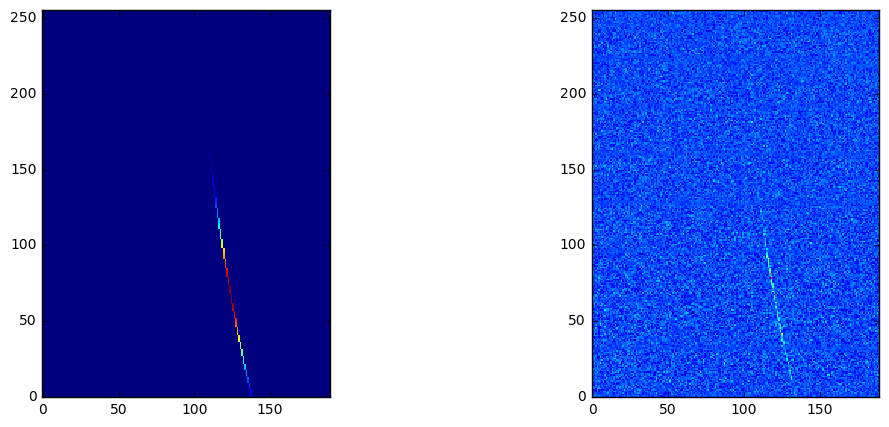

In [33]:
dy, dx = sgram.shape
model = normdm(st['freq'], dx, dy, 30, 68, 32, 100, 557)
fig = pl.figure(figsize=(13,5))
ax = fig.add_subplot(121)
pl.imshow(model, interpolation='nearest', origin='bottom')
ax = fig.add_subplot(122)
pl.imshow(sgram, interpolation='nearest', origin='bottom')

Noise from MAD: 0.0734275679535


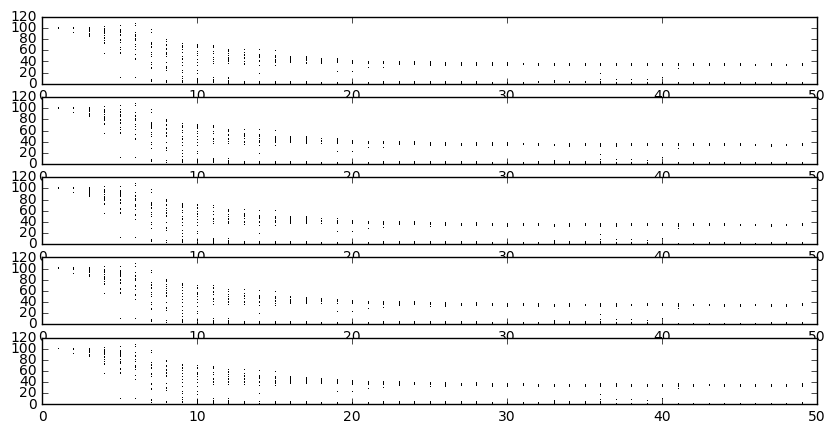

In [34]:
ndim, nwalkers = 5, 200
p0 = (100, 60, 60, 100, 557) #, 2)
pos = [np.array(p0) + 0.1*np.random.randn(ndim) for i in range(nwalkers)]
std = madstd(sgram, 10)
print('Noise from MAD: {0}'.format(std))
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(st['freq'], sgram, std))

end = sampler.run_mcmc(pos, 500)
fig = pl.figure(figsize=(10,5))
ax = fig.add_subplot(511)
plot = ax.plot(sampler.chain[::10,::10,0].transpose(), ',k')
ax = fig.add_subplot(512)
plot = ax.plot(sampler.chain[::10,::10,0].transpose(), ',k')
ax = fig.add_subplot(513)
plot = ax.plot(sampler.chain[::10,::10,0].transpose(), ',k')
ax = fig.add_subplot(514)
plot = ax.plot(sampler.chain[::10,::10,0].transpose(), ',k')
ax = fig.add_subplot(515)
plot = ax.plot(sampler.chain[::10,::10,0].transpose(), ',k')

2016-12-27 07:52:13,877 - root - WARNING - Too few points to create valid contours
2016-12-27 07:52:13,937 - root - WARNING - Too few points to create valid contours
2016-12-27 07:52:13,981 - root - WARNING - Too few points to create valid contours
2016-12-27 07:52:14,041 - root - WARNING - Too few points to create valid contours
2016-12-27 07:52:14,084 - root - WARNING - Too few points to create valid contours
2016-12-27 07:52:14,127 - root - WARNING - Too few points to create valid contours
2016-12-27 07:52:14,190 - root - WARNING - Too few points to create valid contours
2016-12-27 07:52:14,233 - root - WARNING - Too few points to create valid contours
2016-12-27 07:52:14,321 - root - WARNING - Too few points to create valid contours


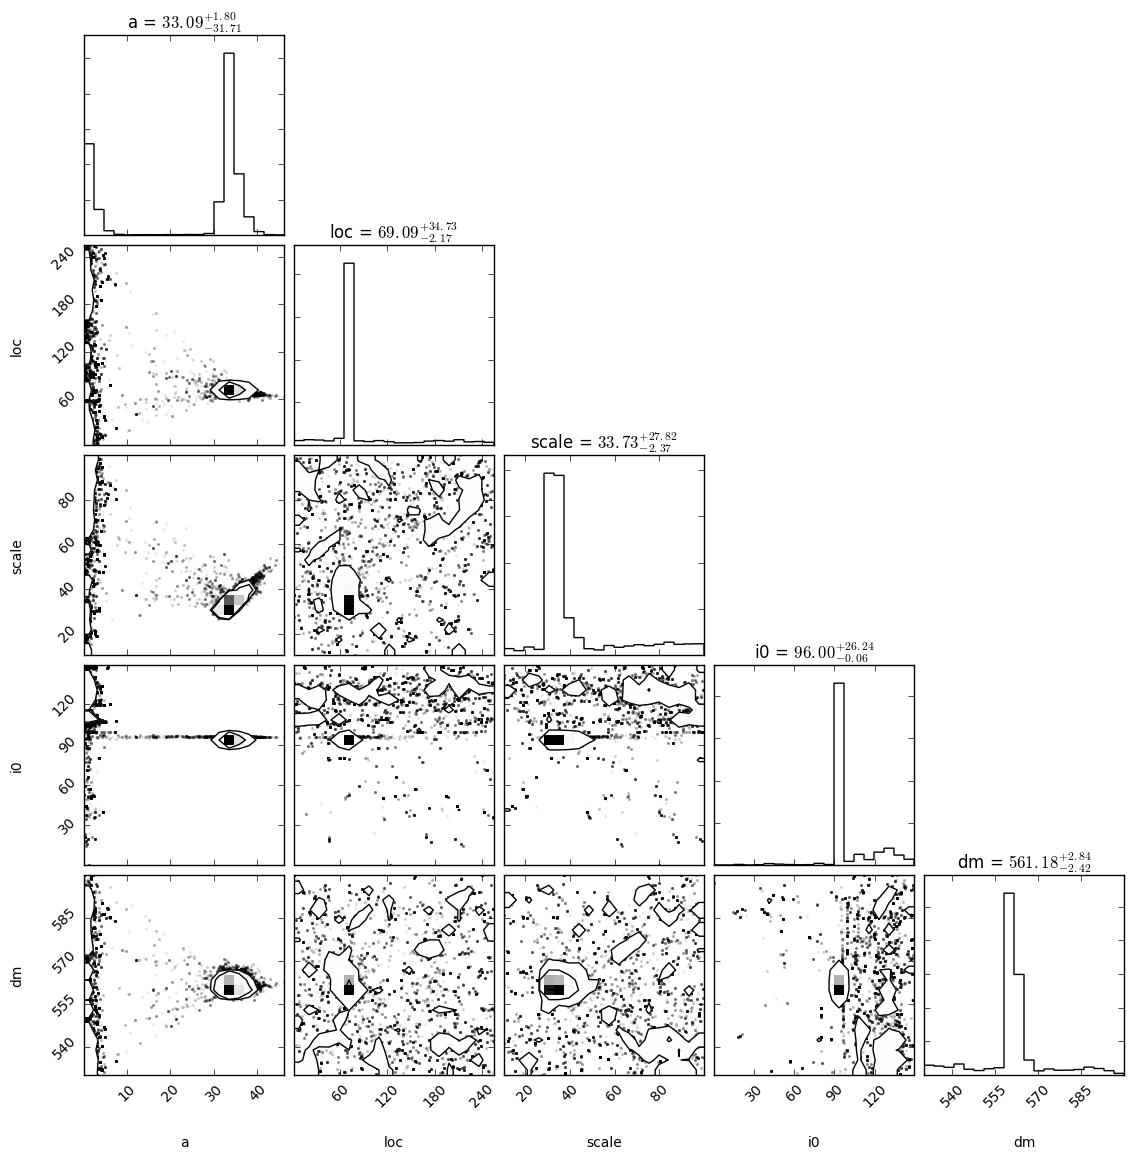

In [35]:
samples = sampler.chain[:, 200:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=["a", "loc", "scale", "i0", "dm"], show_titles=True)

In [36]:
key = '57633_scan7'
st, data, u, v, w = read[key]
scale = getscale(st)
sgram = correctdata(st, data*scale, u, v, w, corr='ph').mean(axis=3).mean(axis=1).real.transpose()

Noise from MAD: 0.0717635919799


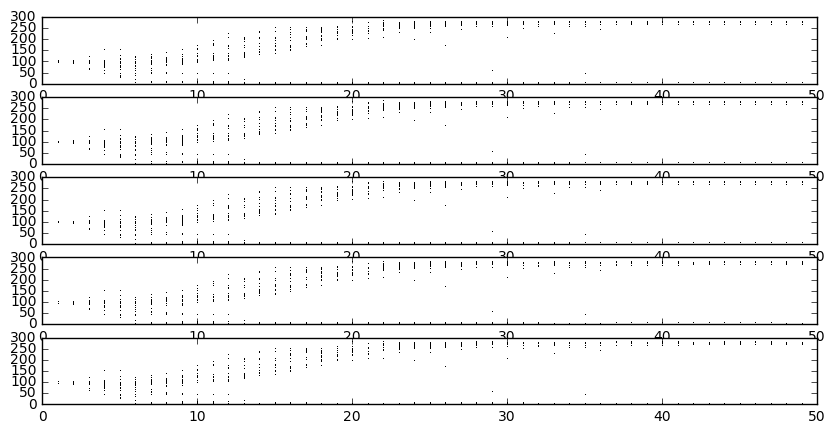

In [37]:
ndim, nwalkers = 5, 200
p0 = (100, 60, 60, 100, 557) #, 2)
pos = [np.array(p0) + 0.1*np.random.randn(ndim) for i in range(nwalkers)]
std = madstd(sgram, 10)
print('Noise from MAD: {0}'.format(std))
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(st['freq'], sgram, std))

end = sampler.run_mcmc(pos, 500)
fig = pl.figure(figsize=(10,5))
ax = fig.add_subplot(511)
plot = ax.plot(sampler.chain[::10,::10,0].transpose(), ',k')
ax = fig.add_subplot(512)
plot = ax.plot(sampler.chain[::10,::10,0].transpose(), ',k')
ax = fig.add_subplot(513)
plot = ax.plot(sampler.chain[::10,::10,0].transpose(), ',k')
ax = fig.add_subplot(514)
plot = ax.plot(sampler.chain[::10,::10,0].transpose(), ',k')
ax = fig.add_subplot(515)
plot = ax.plot(sampler.chain[::10,::10,0].transpose(), ',k')

2016-12-27 07:54:09,908 - root - WARNING - Too few points to create valid contours
2016-12-27 07:54:09,975 - root - WARNING - Too few points to create valid contours
2016-12-27 07:54:10,018 - root - WARNING - Too few points to create valid contours
2016-12-27 07:54:10,078 - root - WARNING - Too few points to create valid contours
2016-12-27 07:54:10,121 - root - WARNING - Too few points to create valid contours
2016-12-27 07:54:10,164 - root - WARNING - Too few points to create valid contours
2016-12-27 07:54:10,231 - root - WARNING - Too few points to create valid contours
2016-12-27 07:54:10,274 - root - WARNING - Too few points to create valid contours
2016-12-27 07:54:10,317 - root - WARNING - Too few points to create valid contours
2016-12-27 07:54:10,361 - root - WARNING - Too few points to create valid contours


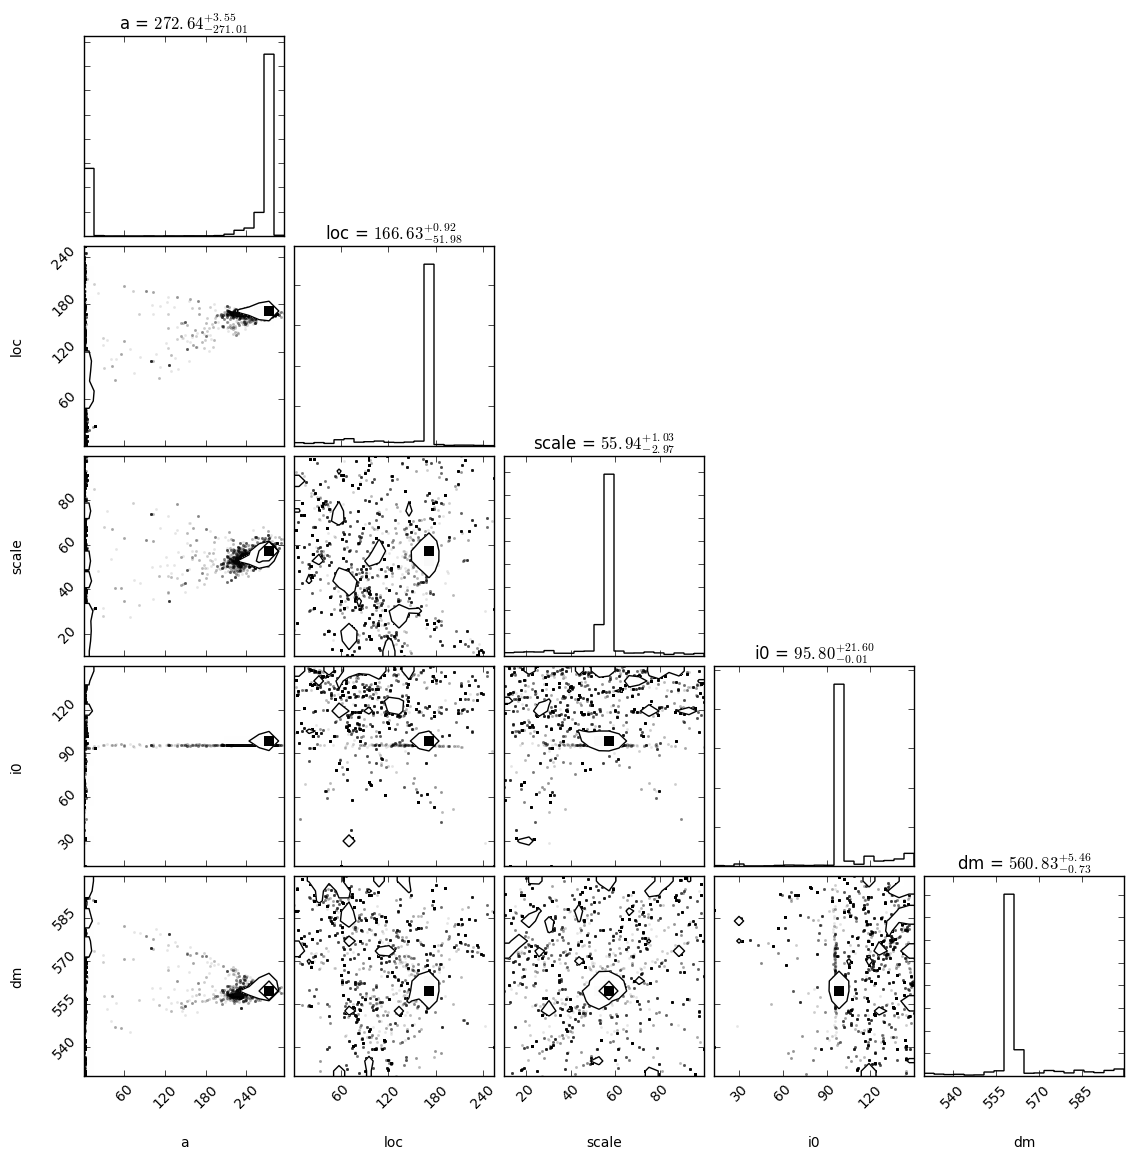

In [38]:
samples = sampler.chain[:, 200:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=["a", "loc", "scale", "i0", "dm"], show_titles=True)

In [39]:
key = '57633_scan13'
st, data, u, v, w = read[key]
scale = getscale(st)
sgram = correctdata(st, data*scale, u, v, w, corr='ph').mean(axis=3).mean(axis=1).real.transpose()

Noise from MAD: 0.0701458151661


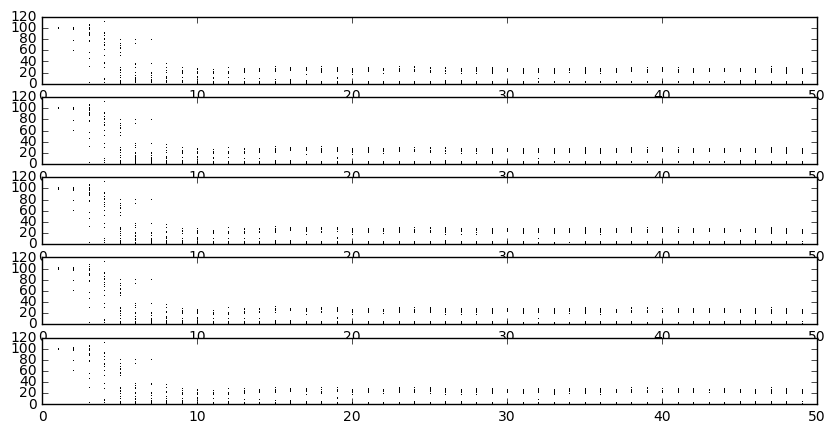

In [40]:
ndim, nwalkers = 5, 200
p0 = (100, 60, 60, 100, 557) #, 2)
pos = [np.array(p0) + 0.1*np.random.randn(ndim) for i in range(nwalkers)]
std = madstd(sgram, 10)
print('Noise from MAD: {0}'.format(std))
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(st['freq'], sgram, std))

end = sampler.run_mcmc(pos, 500)
fig = pl.figure(figsize=(10,5))
ax = fig.add_subplot(511)
plot = ax.plot(sampler.chain[::10,::10,0].transpose(), ',k')
ax = fig.add_subplot(512)
plot = ax.plot(sampler.chain[::10,::10,0].transpose(), ',k')
ax = fig.add_subplot(513)
plot = ax.plot(sampler.chain[::10,::10,0].transpose(), ',k')
ax = fig.add_subplot(514)
plot = ax.plot(sampler.chain[::10,::10,0].transpose(), ',k')
ax = fig.add_subplot(515)
plot = ax.plot(sampler.chain[::10,::10,0].transpose(), ',k')

2016-12-27 07:55:57,831 - root - WARNING - Too few points to create valid contours
2016-12-27 07:55:57,933 - root - WARNING - Too few points to create valid contours
2016-12-27 07:55:57,976 - root - WARNING - Too few points to create valid contours
2016-12-27 07:55:58,075 - root - WARNING - Too few points to create valid contours
2016-12-27 07:55:58,162 - root - WARNING - Too few points to create valid contours


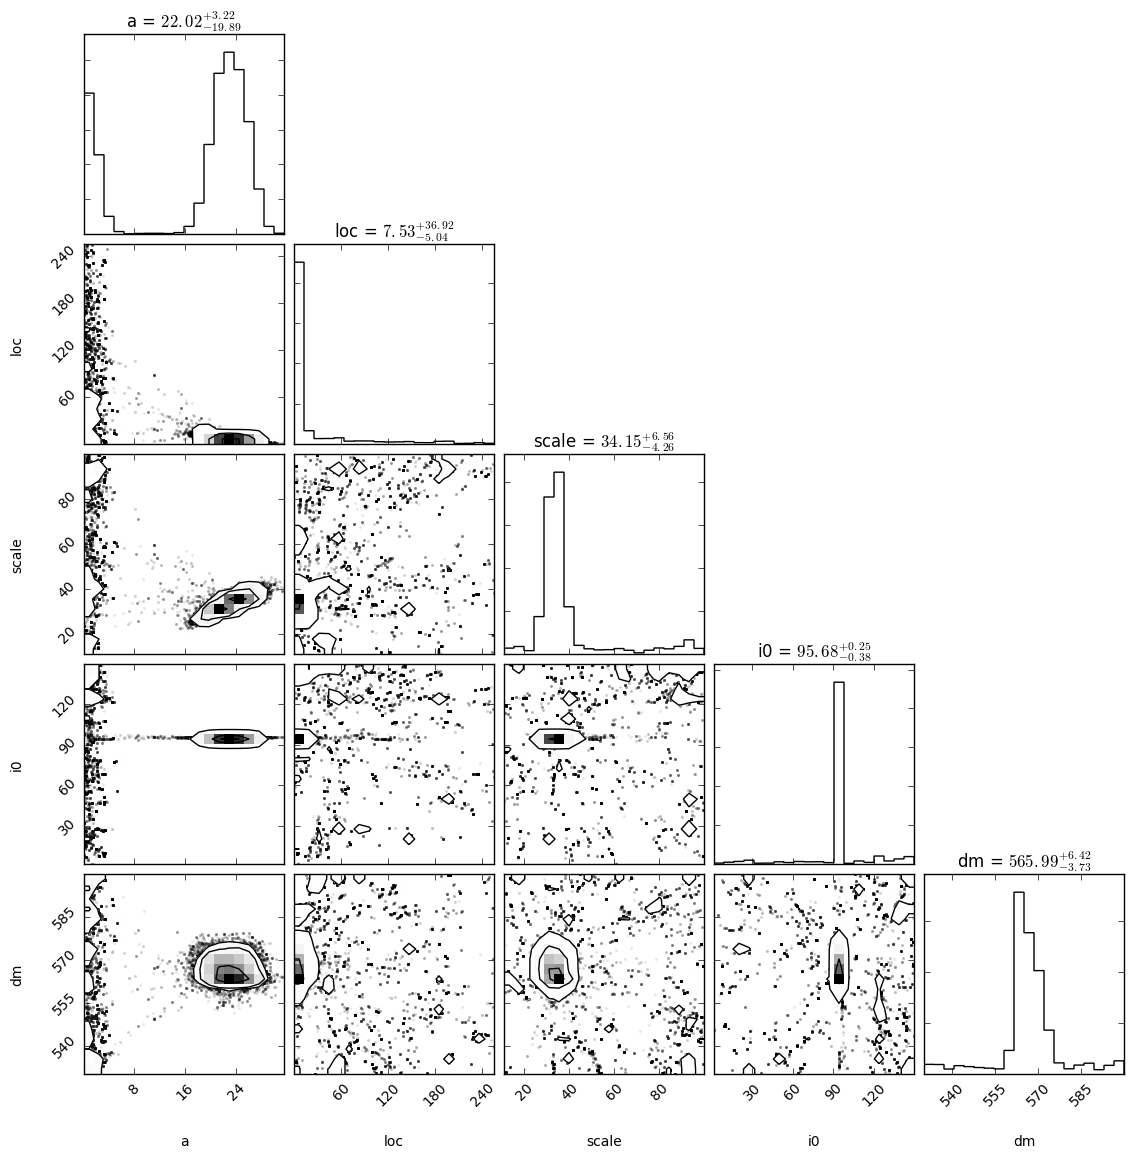

In [41]:
samples = sampler.chain[:, 200:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=["a", "loc", "scale", "i0", "dm"], show_titles=True)

In [42]:
key = '57638'
st, data, u, v, w = read[key]
scale = getscale(st)
sgram = correctdata(st, data*scale, u, v, w, corr='ph').mean(axis=3).mean(axis=1).real.transpose()

2016-12-27 07:56:00,671 - py.warnings - WARNING - /users/claw/miniconda/lib/python2.7/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0

2016-12-27 07:56:00,672 - py.warnings - WARNING - /users/claw/miniconda/lib/python2.7/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))



Noise from MAD: 0.0737063586712


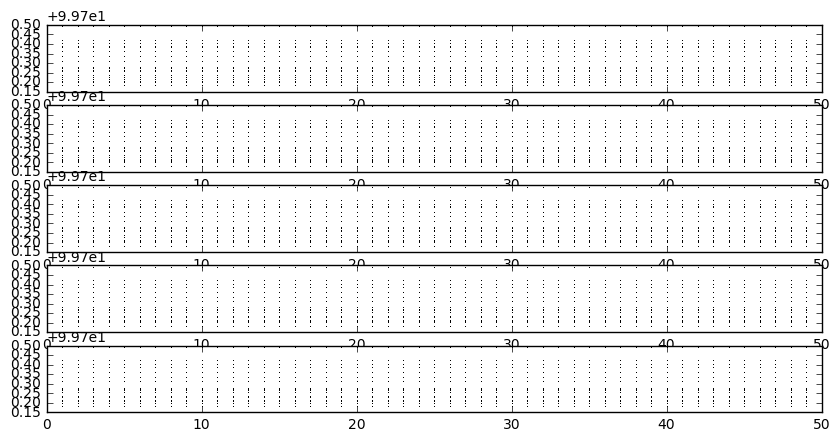

In [43]:
ndim, nwalkers = 5, 200
p0 = (100, 60, 60, 100, 557) #, 2)
pos = [np.array(p0) + 0.1*np.random.randn(ndim) for i in range(nwalkers)]
std = madstd(sgram, 10)
print('Noise from MAD: {0}'.format(std))
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(st['freq'], sgram, std))

end = sampler.run_mcmc(pos, 500)
fig = pl.figure(figsize=(10,5))
ax = fig.add_subplot(511)
plot = ax.plot(sampler.chain[::10,::10,0].transpose(), ',k')
ax = fig.add_subplot(512)
plot = ax.plot(sampler.chain[::10,::10,0].transpose(), ',k')
ax = fig.add_subplot(513)
plot = ax.plot(sampler.chain[::10,::10,0].transpose(), ',k')
ax = fig.add_subplot(514)
plot = ax.plot(sampler.chain[::10,::10,0].transpose(), ',k')
ax = fig.add_subplot(515)
plot = ax.plot(sampler.chain[::10,::10,0].transpose(), ',k')

2016-12-27 07:56:03,851 - root - WARNING - Too few points to create valid contours
2016-12-27 07:56:03,914 - root - WARNING - Too few points to create valid contours
2016-12-27 07:56:03,958 - root - WARNING - Too few points to create valid contours
2016-12-27 07:56:04,020 - root - WARNING - Too few points to create valid contours
2016-12-27 07:56:04,063 - root - WARNING - Too few points to create valid contours
2016-12-27 07:56:04,107 - root - WARNING - Too few points to create valid contours
2016-12-27 07:56:04,172 - root - WARNING - Too few points to create valid contours
2016-12-27 07:56:04,213 - root - WARNING - Too few points to create valid contours
2016-12-27 07:56:04,255 - root - WARNING - Too few points to create valid contours
2016-12-27 07:56:04,298 - root - WARNING - Too few points to create valid contours


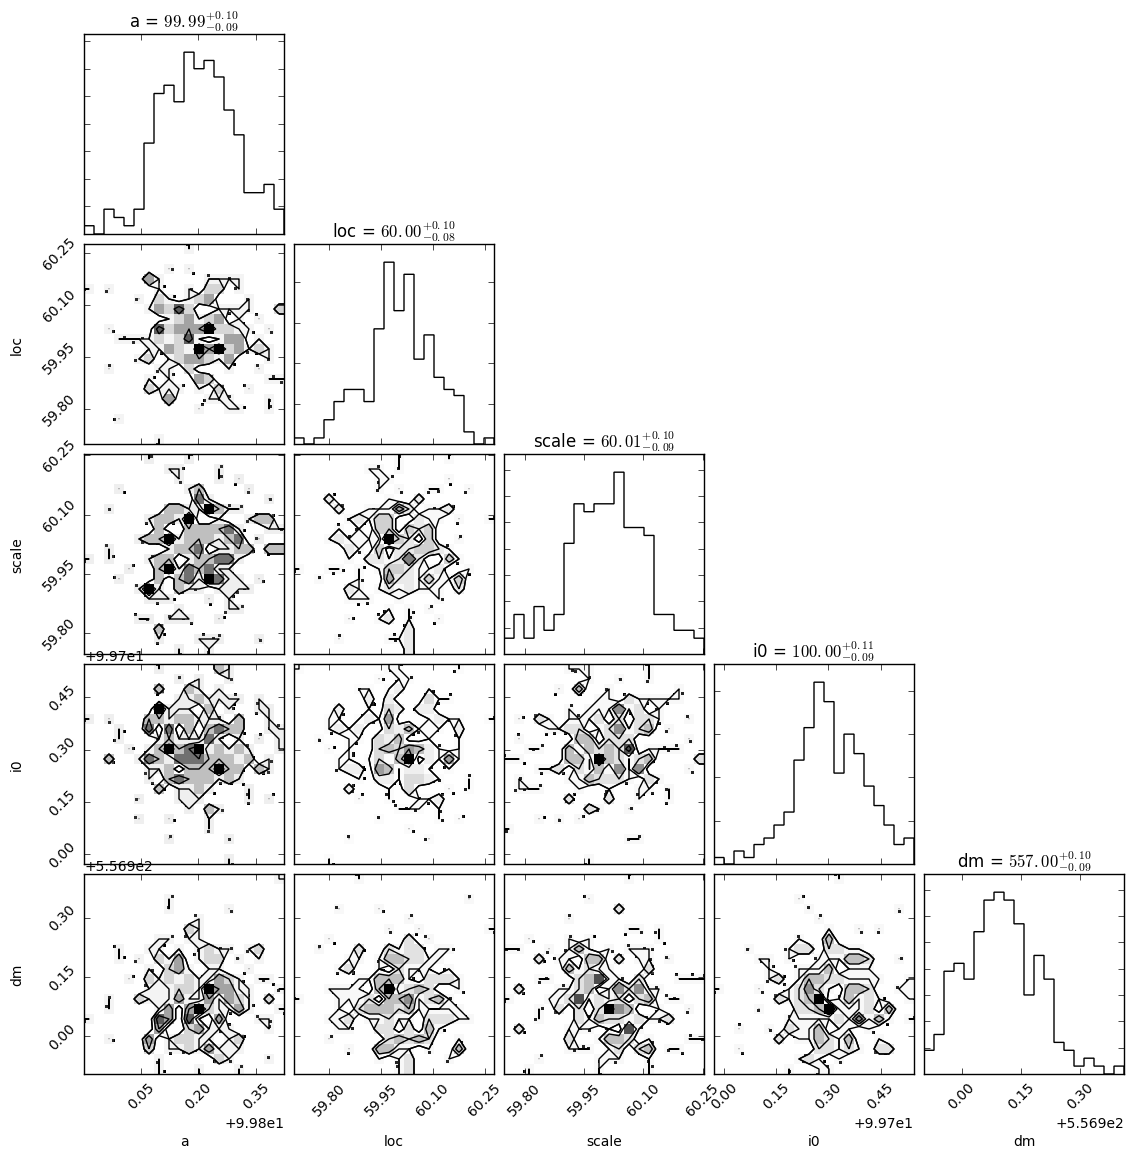

In [44]:
samples = sampler.chain[:, 200:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=["a", "loc", "scale", "i0", "dm"], show_titles=True)

In [45]:
key = '57643'
st, data, u, v, w = read[key]
scale = getscale(st)
sgram = correctdata(st, data*scale, u, v, w, corr='ph').mean(axis=3).mean(axis=1).real.transpose()

Noise from MAD: 0.0651805925725


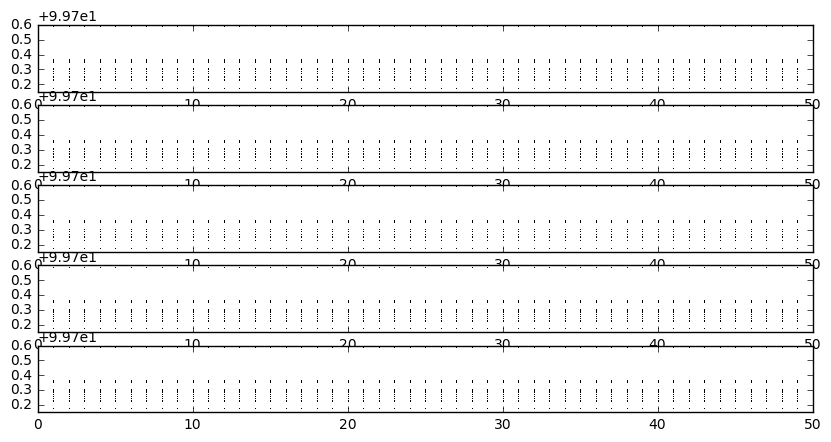

In [46]:
ndim, nwalkers = 5, 200
p0 = (100, 60, 60, 100, 557) #, 2)
pos = [np.array(p0) + 0.1*np.random.randn(ndim) for i in range(nwalkers)]
std = madstd(sgram, 10)
print('Noise from MAD: {0}'.format(std))
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(st['freq'], sgram, std))

end = sampler.run_mcmc(pos, 500)
fig = pl.figure(figsize=(10,5))
ax = fig.add_subplot(511)
plot = ax.plot(sampler.chain[::10,::10,0].transpose(), ',k')
ax = fig.add_subplot(512)
plot = ax.plot(sampler.chain[::10,::10,0].transpose(), ',k')
ax = fig.add_subplot(513)
plot = ax.plot(sampler.chain[::10,::10,0].transpose(), ',k')
ax = fig.add_subplot(514)
plot = ax.plot(sampler.chain[::10,::10,0].transpose(), ',k')
ax = fig.add_subplot(515)
plot = ax.plot(sampler.chain[::10,::10,0].transpose(), ',k')

2016-12-27 07:56:09,938 - root - WARNING - Too few points to create valid contours
2016-12-27 07:56:09,998 - root - WARNING - Too few points to create valid contours
2016-12-27 07:56:10,040 - root - WARNING - Too few points to create valid contours
2016-12-27 07:56:10,146 - root - WARNING - Too few points to create valid contours
2016-12-27 07:56:10,255 - root - WARNING - Too few points to create valid contours
2016-12-27 07:56:10,296 - root - WARNING - Too few points to create valid contours
2016-12-27 07:56:10,339 - root - WARNING - Too few points to create valid contours
2016-12-27 07:56:10,384 - root - WARNING - Too few points to create valid contours


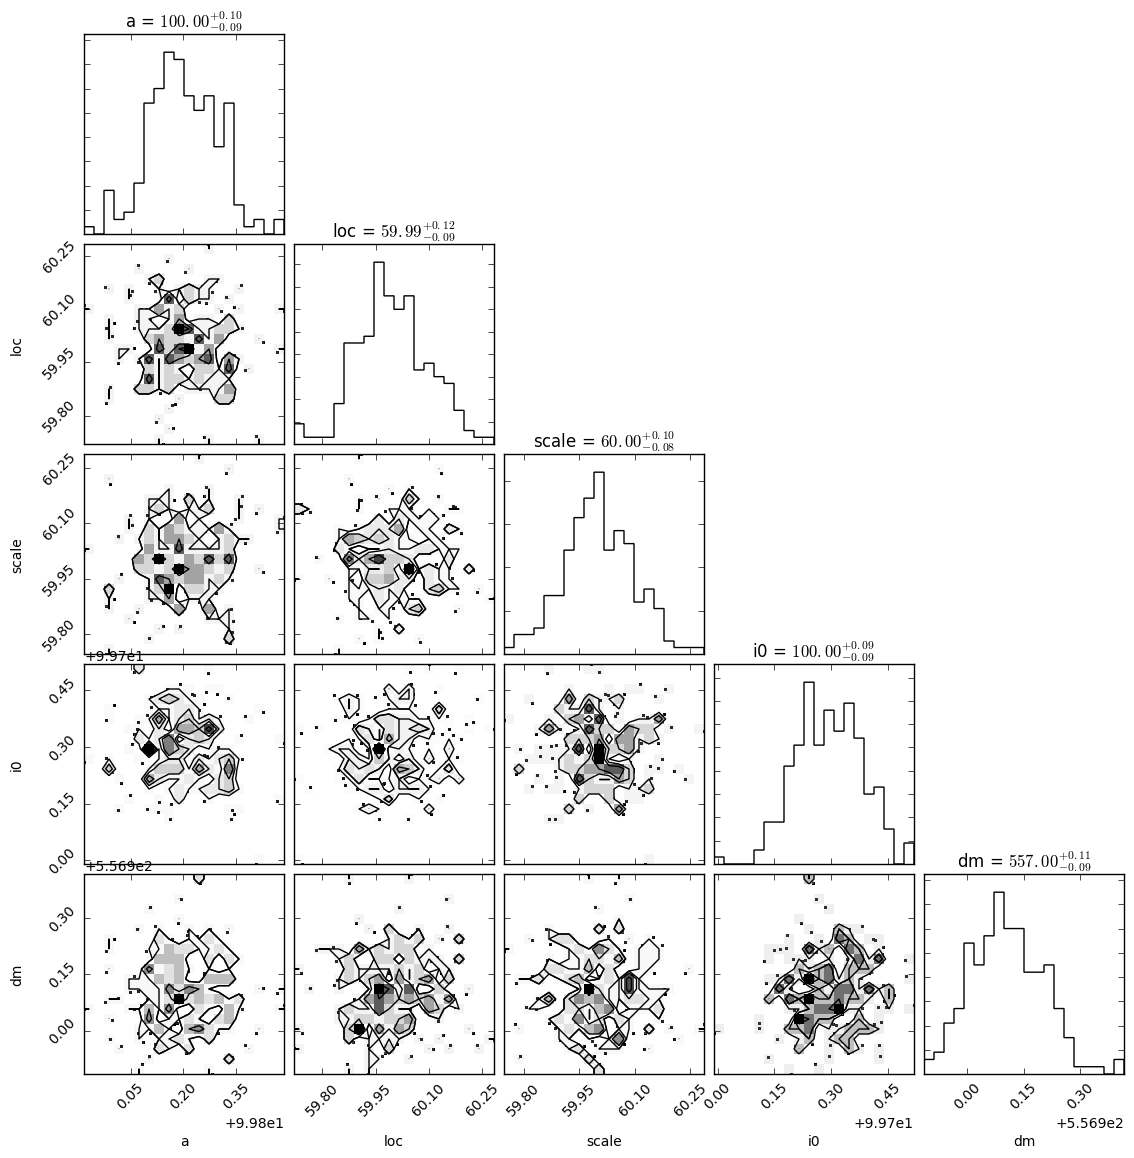

In [47]:
samples = sampler.chain[:, 200:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=["a", "loc", "scale", "i0", "dm", "index"], show_titles=True)

In [48]:
key = '57645'
# forced to use broader spectral model. not ideal...

st, data, u, v, w = read[key]
scale = getscale(st)
sgram = correctdata(st, data*scale, u, v, w, corr='ph').mean(axis=3).mean(axis=1).real.transpose()

Noise from MAD: 0.071387554505


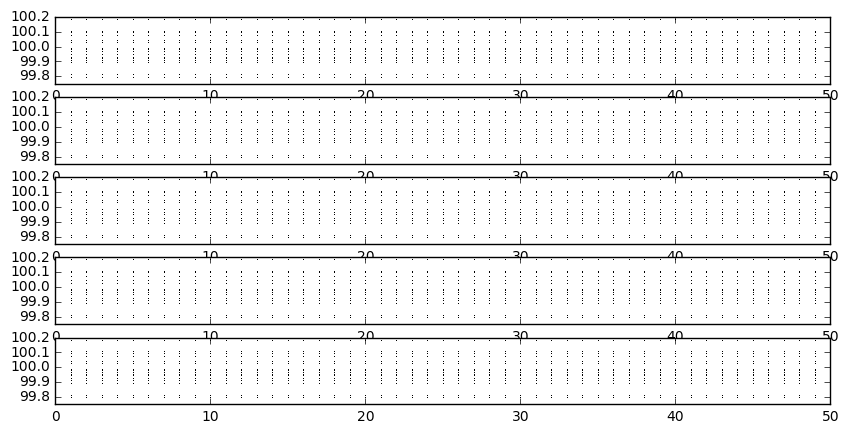

In [49]:
ndim, nwalkers = 5, 200
p0 = (100, 60, 60, 100, 557) #, 2)
pos = [np.array(p0) + 0.1*np.random.randn(ndim) for i in range(nwalkers)]
std = madstd(sgram, 10)
print('Noise from MAD: {0}'.format(std))
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(st['freq'], sgram, std))

end = sampler.run_mcmc(pos, 500)
fig = pl.figure(figsize=(10,5))
ax = fig.add_subplot(511)
plot = ax.plot(sampler.chain[::10,::10,0].transpose(), ',k')
ax = fig.add_subplot(512)
plot = ax.plot(sampler.chain[::10,::10,0].transpose(), ',k')
ax = fig.add_subplot(513)
plot = ax.plot(sampler.chain[::10,::10,0].transpose(), ',k')
ax = fig.add_subplot(514)
plot = ax.plot(sampler.chain[::10,::10,0].transpose(), ',k')
ax = fig.add_subplot(515)
plot = ax.plot(sampler.chain[::10,::10,0].transpose(), ',k')

2016-12-27 07:56:15,911 - root - WARNING - Too few points to create valid contours
2016-12-27 07:56:15,980 - root - WARNING - Too few points to create valid contours
2016-12-27 07:56:16,025 - root - WARNING - Too few points to create valid contours
2016-12-27 07:56:16,089 - root - WARNING - Too few points to create valid contours
2016-12-27 07:56:16,135 - root - WARNING - Too few points to create valid contours
2016-12-27 07:56:16,180 - root - WARNING - Too few points to create valid contours
2016-12-27 07:56:16,242 - root - WARNING - Too few points to create valid contours
2016-12-27 07:56:16,288 - root - WARNING - Too few points to create valid contours
2016-12-27 07:56:16,332 - root - WARNING - Too few points to create valid contours
2016-12-27 07:56:16,379 - root - WARNING - Too few points to create valid contours


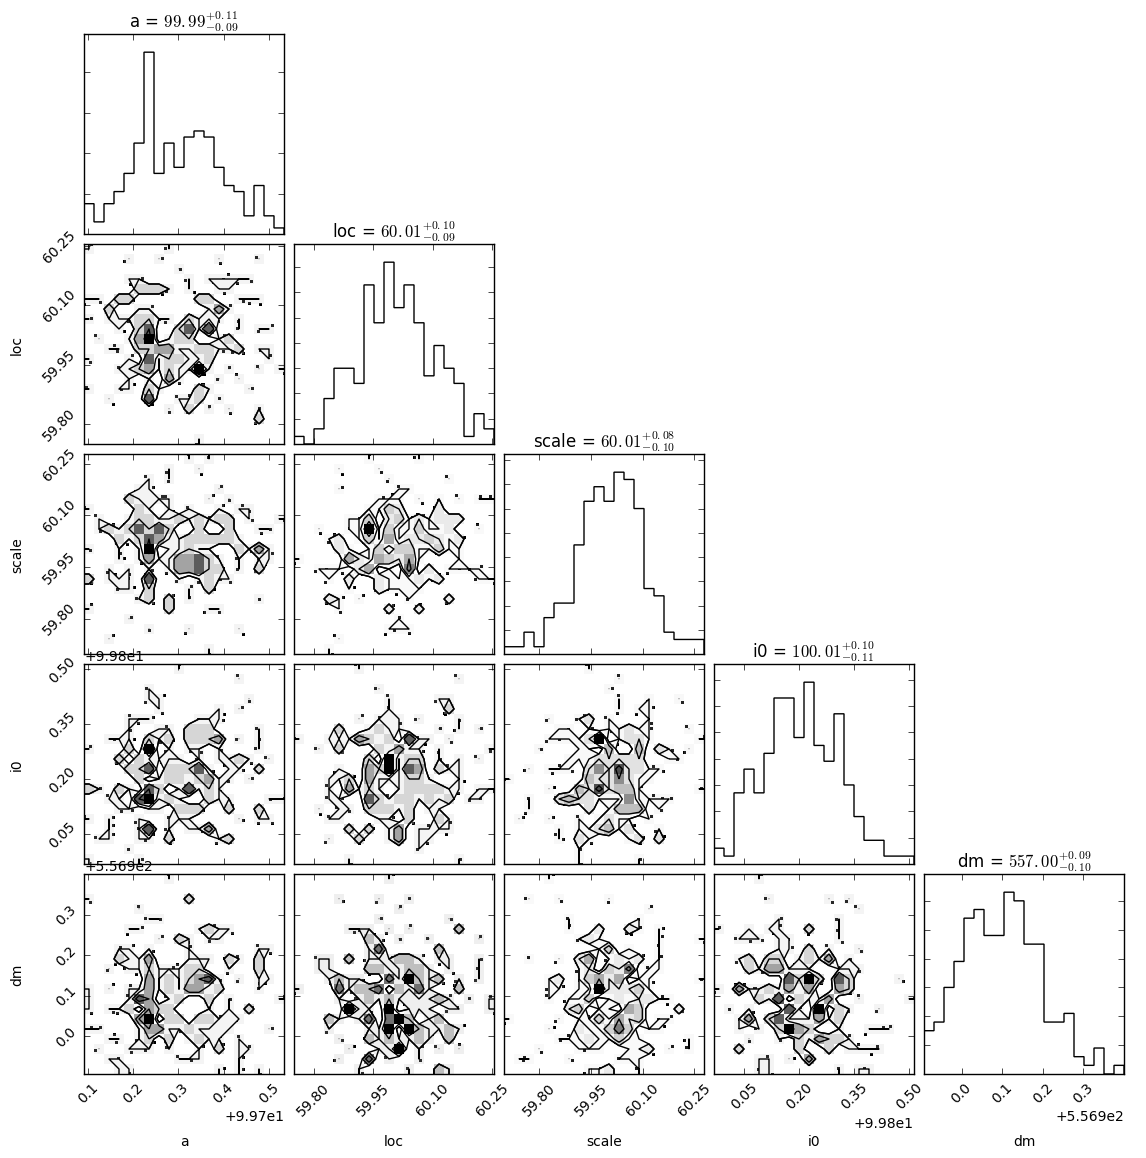

In [50]:
samples = sampler.chain[:, 200:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=["a", "loc", "scale", "i0", "dm"], show_titles=True)

In [51]:
key = '57646'
st, data, u, v, w = read[key]
scale = getscale(st)
sgram = correctdata(st, data*scale, u, v, w, corr='ph').mean(axis=3).mean(axis=1).real.transpose()

Noise from MAD: 0.0706167752618


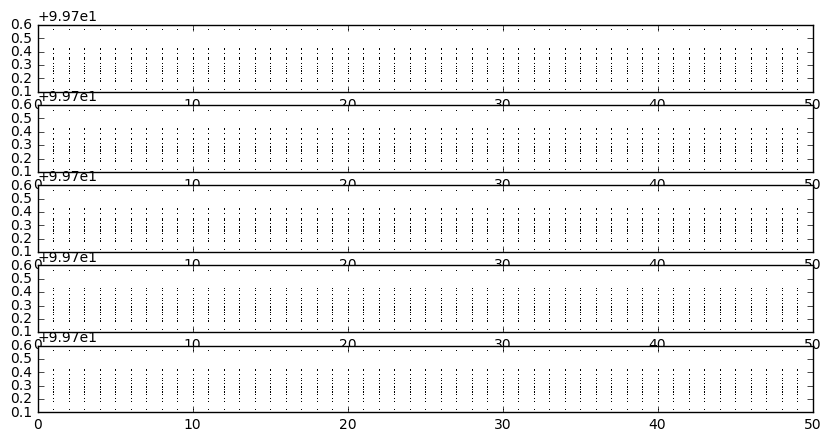

In [52]:
ndim, nwalkers = 5, 200
p0 = (100, 60, 60, 100, 557) #, 2)
pos = [np.array(p0) + 0.1*np.random.randn(ndim) for i in range(nwalkers)]
std = madstd(sgram, 10)
print('Noise from MAD: {0}'.format(std))
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(st['freq'], sgram, std))

end = sampler.run_mcmc(pos, 500)
fig = pl.figure(figsize=(10,5))
ax = fig.add_subplot(511)
plot = ax.plot(sampler.chain[::10,::10,0].transpose(), ',k')
ax = fig.add_subplot(512)
plot = ax.plot(sampler.chain[::10,::10,0].transpose(), ',k')
ax = fig.add_subplot(513)
plot = ax.plot(sampler.chain[::10,::10,0].transpose(), ',k')
ax = fig.add_subplot(514)
plot = ax.plot(sampler.chain[::10,::10,0].transpose(), ',k')
ax = fig.add_subplot(515)
plot = ax.plot(sampler.chain[::10,::10,0].transpose(), ',k')

2016-12-27 07:56:21,981 - root - WARNING - Too few points to create valid contours
2016-12-27 07:56:22,040 - root - WARNING - Too few points to create valid contours
2016-12-27 07:56:22,081 - root - WARNING - Too few points to create valid contours
2016-12-27 07:56:22,145 - root - WARNING - Too few points to create valid contours
2016-12-27 07:56:22,190 - root - WARNING - Too few points to create valid contours
2016-12-27 07:56:22,237 - root - WARNING - Too few points to create valid contours
2016-12-27 07:56:22,303 - root - WARNING - Too few points to create valid contours
2016-12-27 07:56:22,345 - root - WARNING - Too few points to create valid contours
2016-12-27 07:56:22,389 - root - WARNING - Too few points to create valid contours
2016-12-27 07:56:22,432 - root - WARNING - Too few points to create valid contours


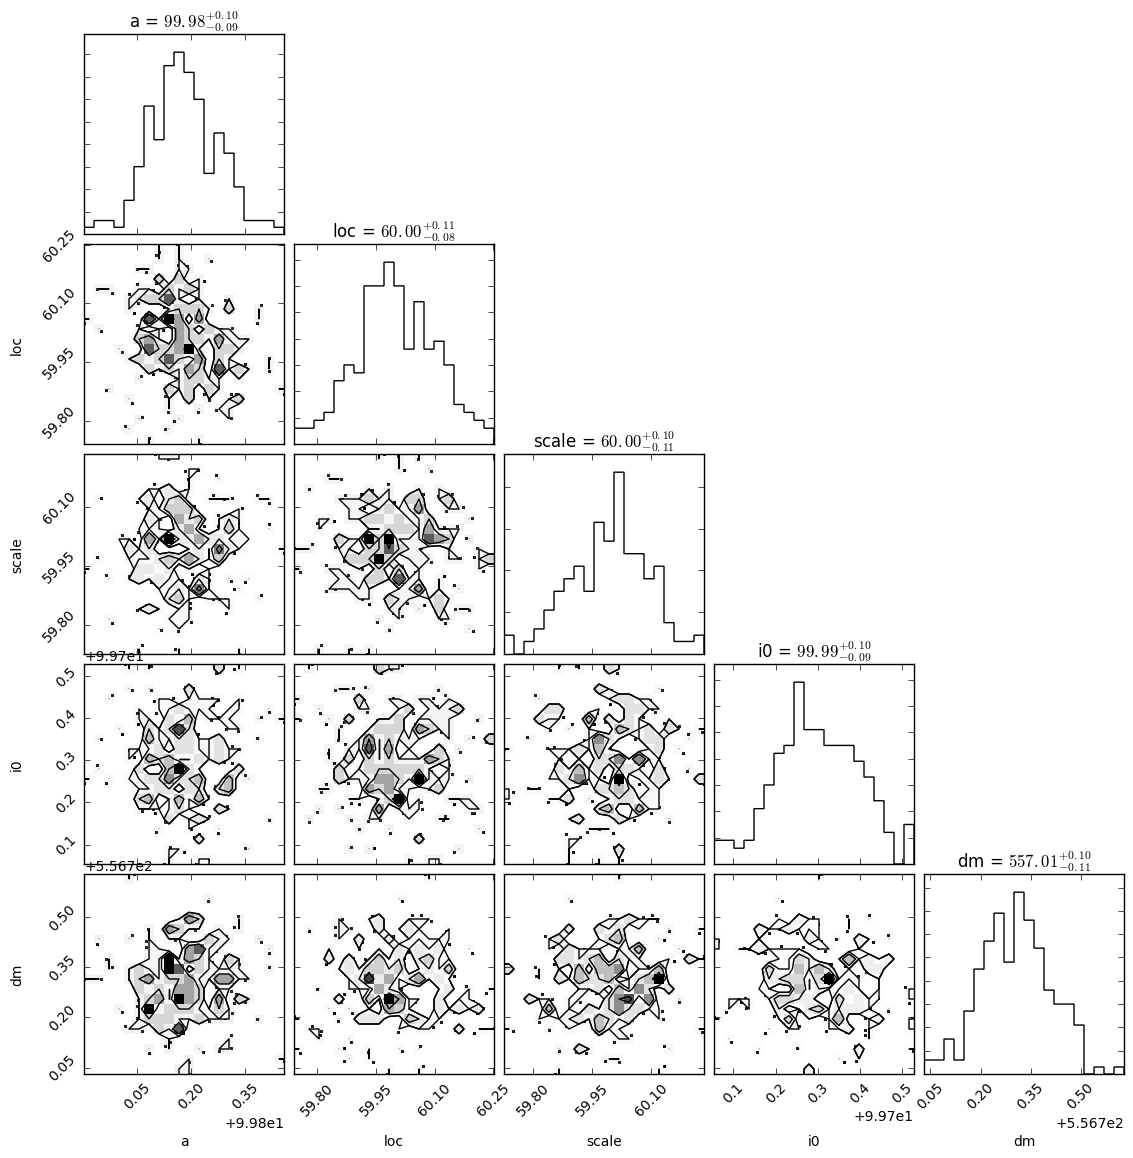

In [53]:
samples = sampler.chain[:, 200:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=["a", "loc", "scale", "i0", "dm"], show_titles=True)

In [54]:
key = '57648'
st, data, u, v, w = read[key]
scale = getscale(st)
sgram = correctdata(st, data*scale, u, v, w, corr='ph').mean(axis=3).mean(axis=1).real.transpose()

Noise from MAD: 0.0729772025969


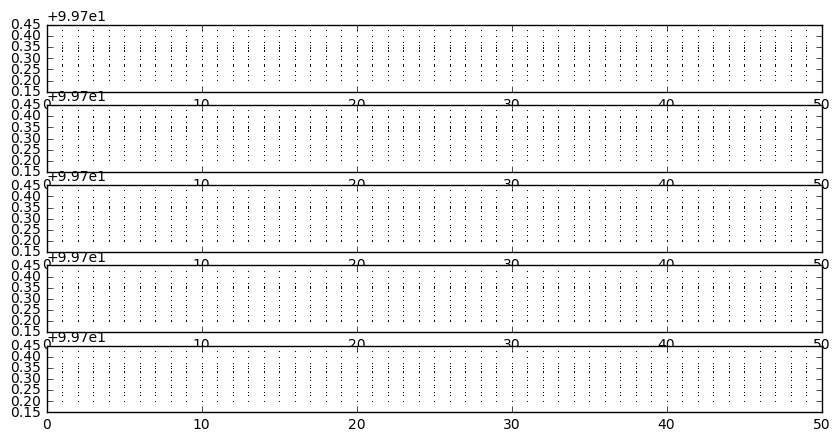

In [55]:
ndim, nwalkers = 5, 200
p0 = (100, 60, 60, 100, 557) #, 2)
pos = [np.array(p0) + 0.1*np.random.randn(ndim) for i in range(nwalkers)]
std = madstd(sgram, 10)
print('Noise from MAD: {0}'.format(std))
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(st['freq'], sgram, std))

end = sampler.run_mcmc(pos, 500)
fig = pl.figure(figsize=(10,5))
ax = fig.add_subplot(511)
plot = ax.plot(sampler.chain[::10,::10,0].transpose(), ',k')
ax = fig.add_subplot(512)
plot = ax.plot(sampler.chain[::10,::10,0].transpose(), ',k')
ax = fig.add_subplot(513)
plot = ax.plot(sampler.chain[::10,::10,0].transpose(), ',k')
ax = fig.add_subplot(514)
plot = ax.plot(sampler.chain[::10,::10,0].transpose(), ',k')
ax = fig.add_subplot(515)
plot = ax.plot(sampler.chain[::10,::10,0].transpose(), ',k')

2016-12-27 07:56:27,987 - root - WARNING - Too few points to create valid contours
2016-12-27 07:56:28,048 - root - WARNING - Too few points to create valid contours
2016-12-27 07:56:28,151 - root - WARNING - Too few points to create valid contours
2016-12-27 07:56:28,197 - root - WARNING - Too few points to create valid contours
2016-12-27 07:56:28,241 - root - WARNING - Too few points to create valid contours
2016-12-27 07:56:28,299 - root - WARNING - Too few points to create valid contours
2016-12-27 07:56:28,344 - root - WARNING - Too few points to create valid contours
2016-12-27 07:56:28,387 - root - WARNING - Too few points to create valid contours
2016-12-27 07:56:28,431 - root - WARNING - Too few points to create valid contours


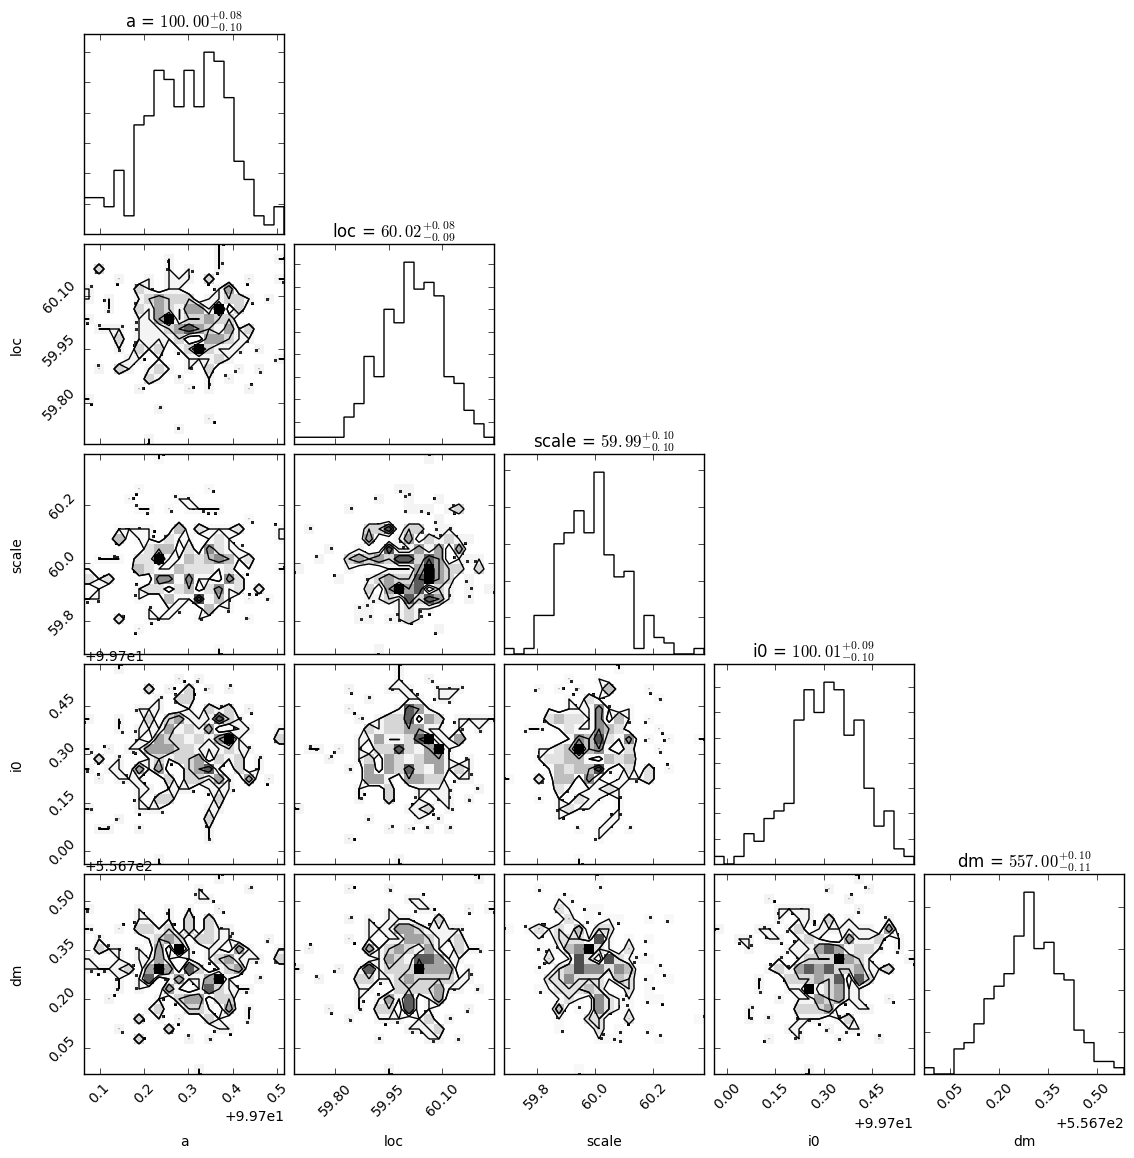

In [56]:
samples = sampler.chain[:, 200:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=["a", "loc", "scale", "i0", "dm"], show_titles=True)

In [57]:
key = '57649'
st, data, u, v, w = read[key]
scale = getscale(st)
sgram = correctdata(st, data*scale, u, v, w, corr='ph').mean(axis=3).mean(axis=1).real.transpose()

Noise from MAD: 0.070757296548


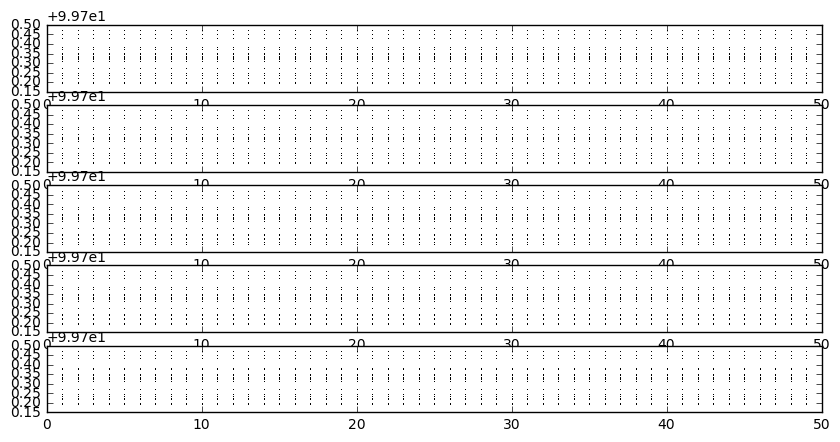

In [58]:
ndim, nwalkers = 5, 200
p0 = (100, 60, 60, 100, 557) #, 2)
pos = [np.array(p0) + 0.1*np.random.randn(ndim) for i in range(nwalkers)]
std = madstd(sgram, 10)
print('Noise from MAD: {0}'.format(std))
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(st['freq'], sgram, std))

end = sampler.run_mcmc(pos, 500)
fig = pl.figure(figsize=(10,5))
ax = fig.add_subplot(511)
plot = ax.plot(sampler.chain[::10,::10,0].transpose(), ',k')
ax = fig.add_subplot(512)
plot = ax.plot(sampler.chain[::10,::10,0].transpose(), ',k')
ax = fig.add_subplot(513)
plot = ax.plot(sampler.chain[::10,::10,0].transpose(), ',k')
ax = fig.add_subplot(514)
plot = ax.plot(sampler.chain[::10,::10,0].transpose(), ',k')
ax = fig.add_subplot(515)
plot = ax.plot(sampler.chain[::10,::10,0].transpose(), ',k')

2016-12-27 07:56:34,096 - root - WARNING - Too few points to create valid contours
2016-12-27 07:56:34,204 - root - WARNING - Too few points to create valid contours
2016-12-27 07:56:34,248 - root - WARNING - Too few points to create valid contours
2016-12-27 07:56:34,354 - root - WARNING - Too few points to create valid contours
2016-12-27 07:56:34,398 - root - WARNING - Too few points to create valid contours
2016-12-27 07:56:34,443 - root - WARNING - Too few points to create valid contours


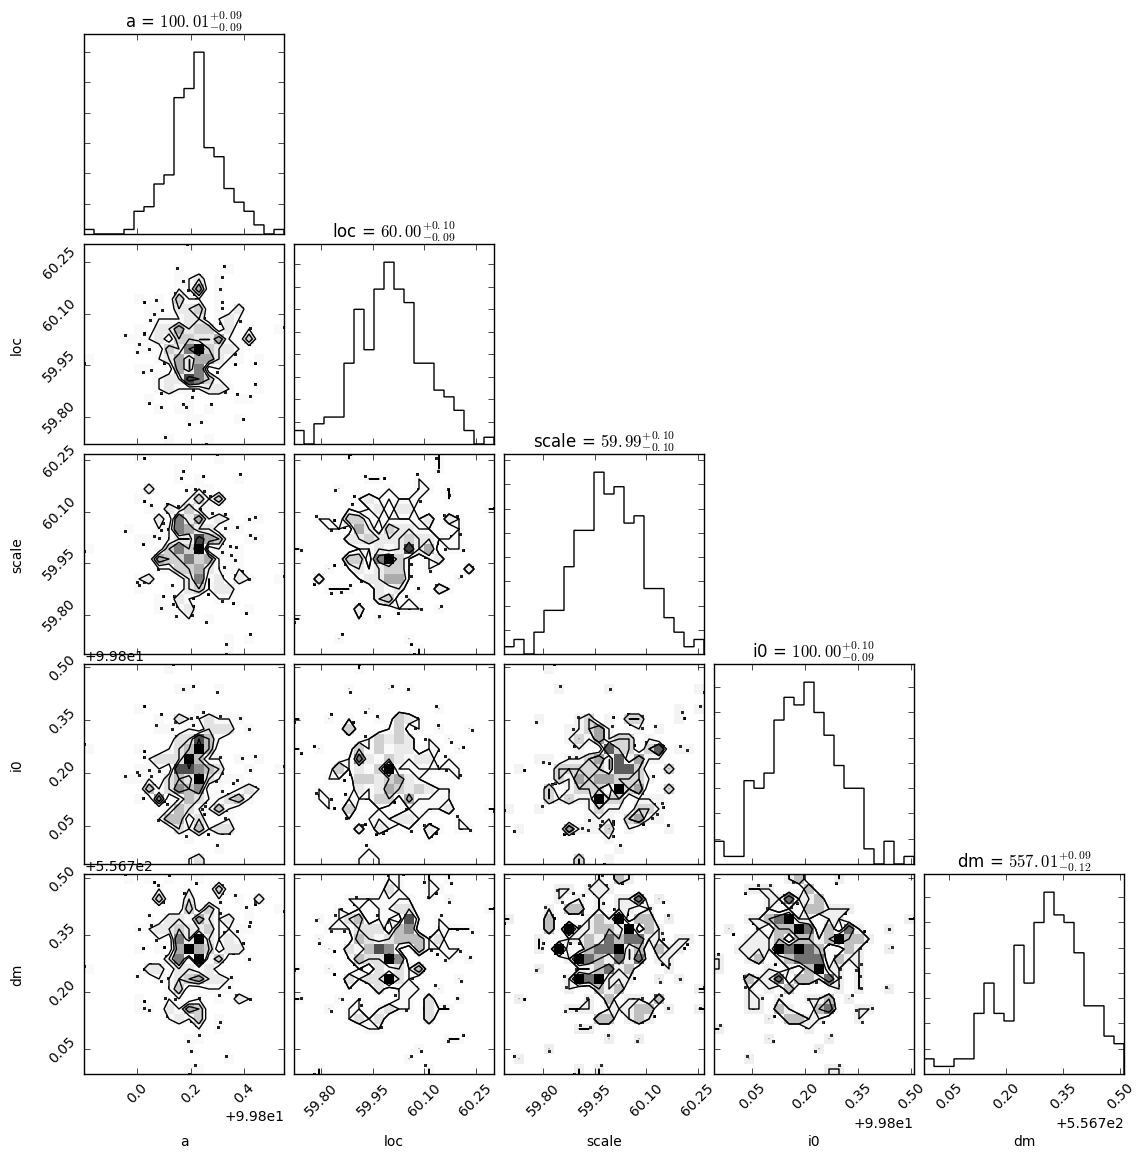

In [59]:
samples = sampler.chain[:, 200:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=["a", "loc", "scale", "i0", "dm"], show_titles=True)

key 57623 not found
key 57633_scan7 not found
key 57633_scan13 not found
key 57638 not found
key 57643 not found
key 57645 not found
key 57646 not found
key 57648 not found
key 57649 not found


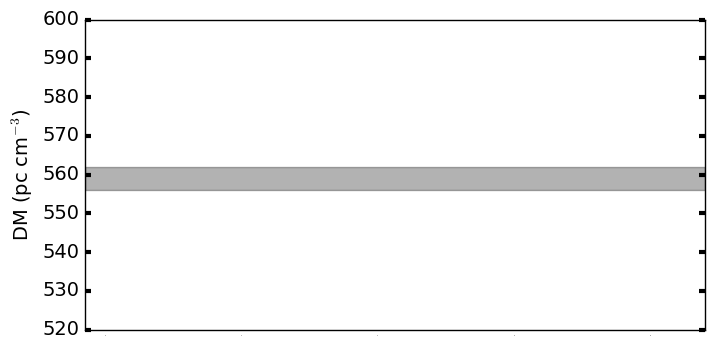

In [60]:
pl.figure(figsize=(8,4))
ax = pl.subplot(111)
i=0
keys = ['57623', '57633_scan7', '57633_scan13', '57638', '57643', '57645', '57646', '57648', '57649']
label = ['57623', '57633.68', '57633.70', '57638', '57643', '57645', '57646', '57648', '57649']
for key in keys:
    try:
        t0, t1, d0, d1 = spec_ci[key]
        pl.plot([i, i], [d0, d1], '.-k')
        pl.text(i+0.1, min(d1, 610), str(label[i]), rotation=65, fontsize=14, verticalalignment='bottom')
    except:
        print('key {0} not found'.format(key))
        pass
    i += 1

#pl.plot([0,i], [557, 557], 'k--')
ax.axhspan(556, 562, alpha=0.3, color='k')
pl.xlim(-0.3,8.8)
pl.ylim(520,600)
pl.ylabel('DM (pc cm$^{-3}$)', fontsize=14)
xt = pl.setp(ax.get_xticklabels(), fontsize=0)
yt = pl.setp(ax.get_yticklabels(), fontsize=14)
ax.xaxis.set_tick_params(width=0, color='k')
ax.yaxis.set_tick_params(width=3, color='k')